In [45]:
library(repr)
options(repr.plot.width=16, repr.plot.height=9)

# 英明的马尔可夫国王和他的岛屿王国

In [10]:
set.seed(8)

num_weeks <- 1e5
positions <- rep(0, num_weeks)
current   <- 10
for (i in 1:num_weeks) {
  # record current position
  positions[i] <- current
  # flip coin to generate proposal
  proposal <- current + sample(c(-1, 1), size = 1)
  # now make sure he loops around the archipelago
  if (proposal < 1) proposal <- 10
  if (proposal > 10) proposal <- 1
  # move?
  prob_move <- proposal / current
  current   <- ifelse(runif(1) < prob_move, proposal, current)
}

In [15]:
library(extrafont)
font_import()
loadfonts(device = "postscript")    #使用hrbrthemes之前需要载入字体

Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n]  n


Exiting.



Warning message:
“Removed 99800 rows containing missing values (geom_point).”


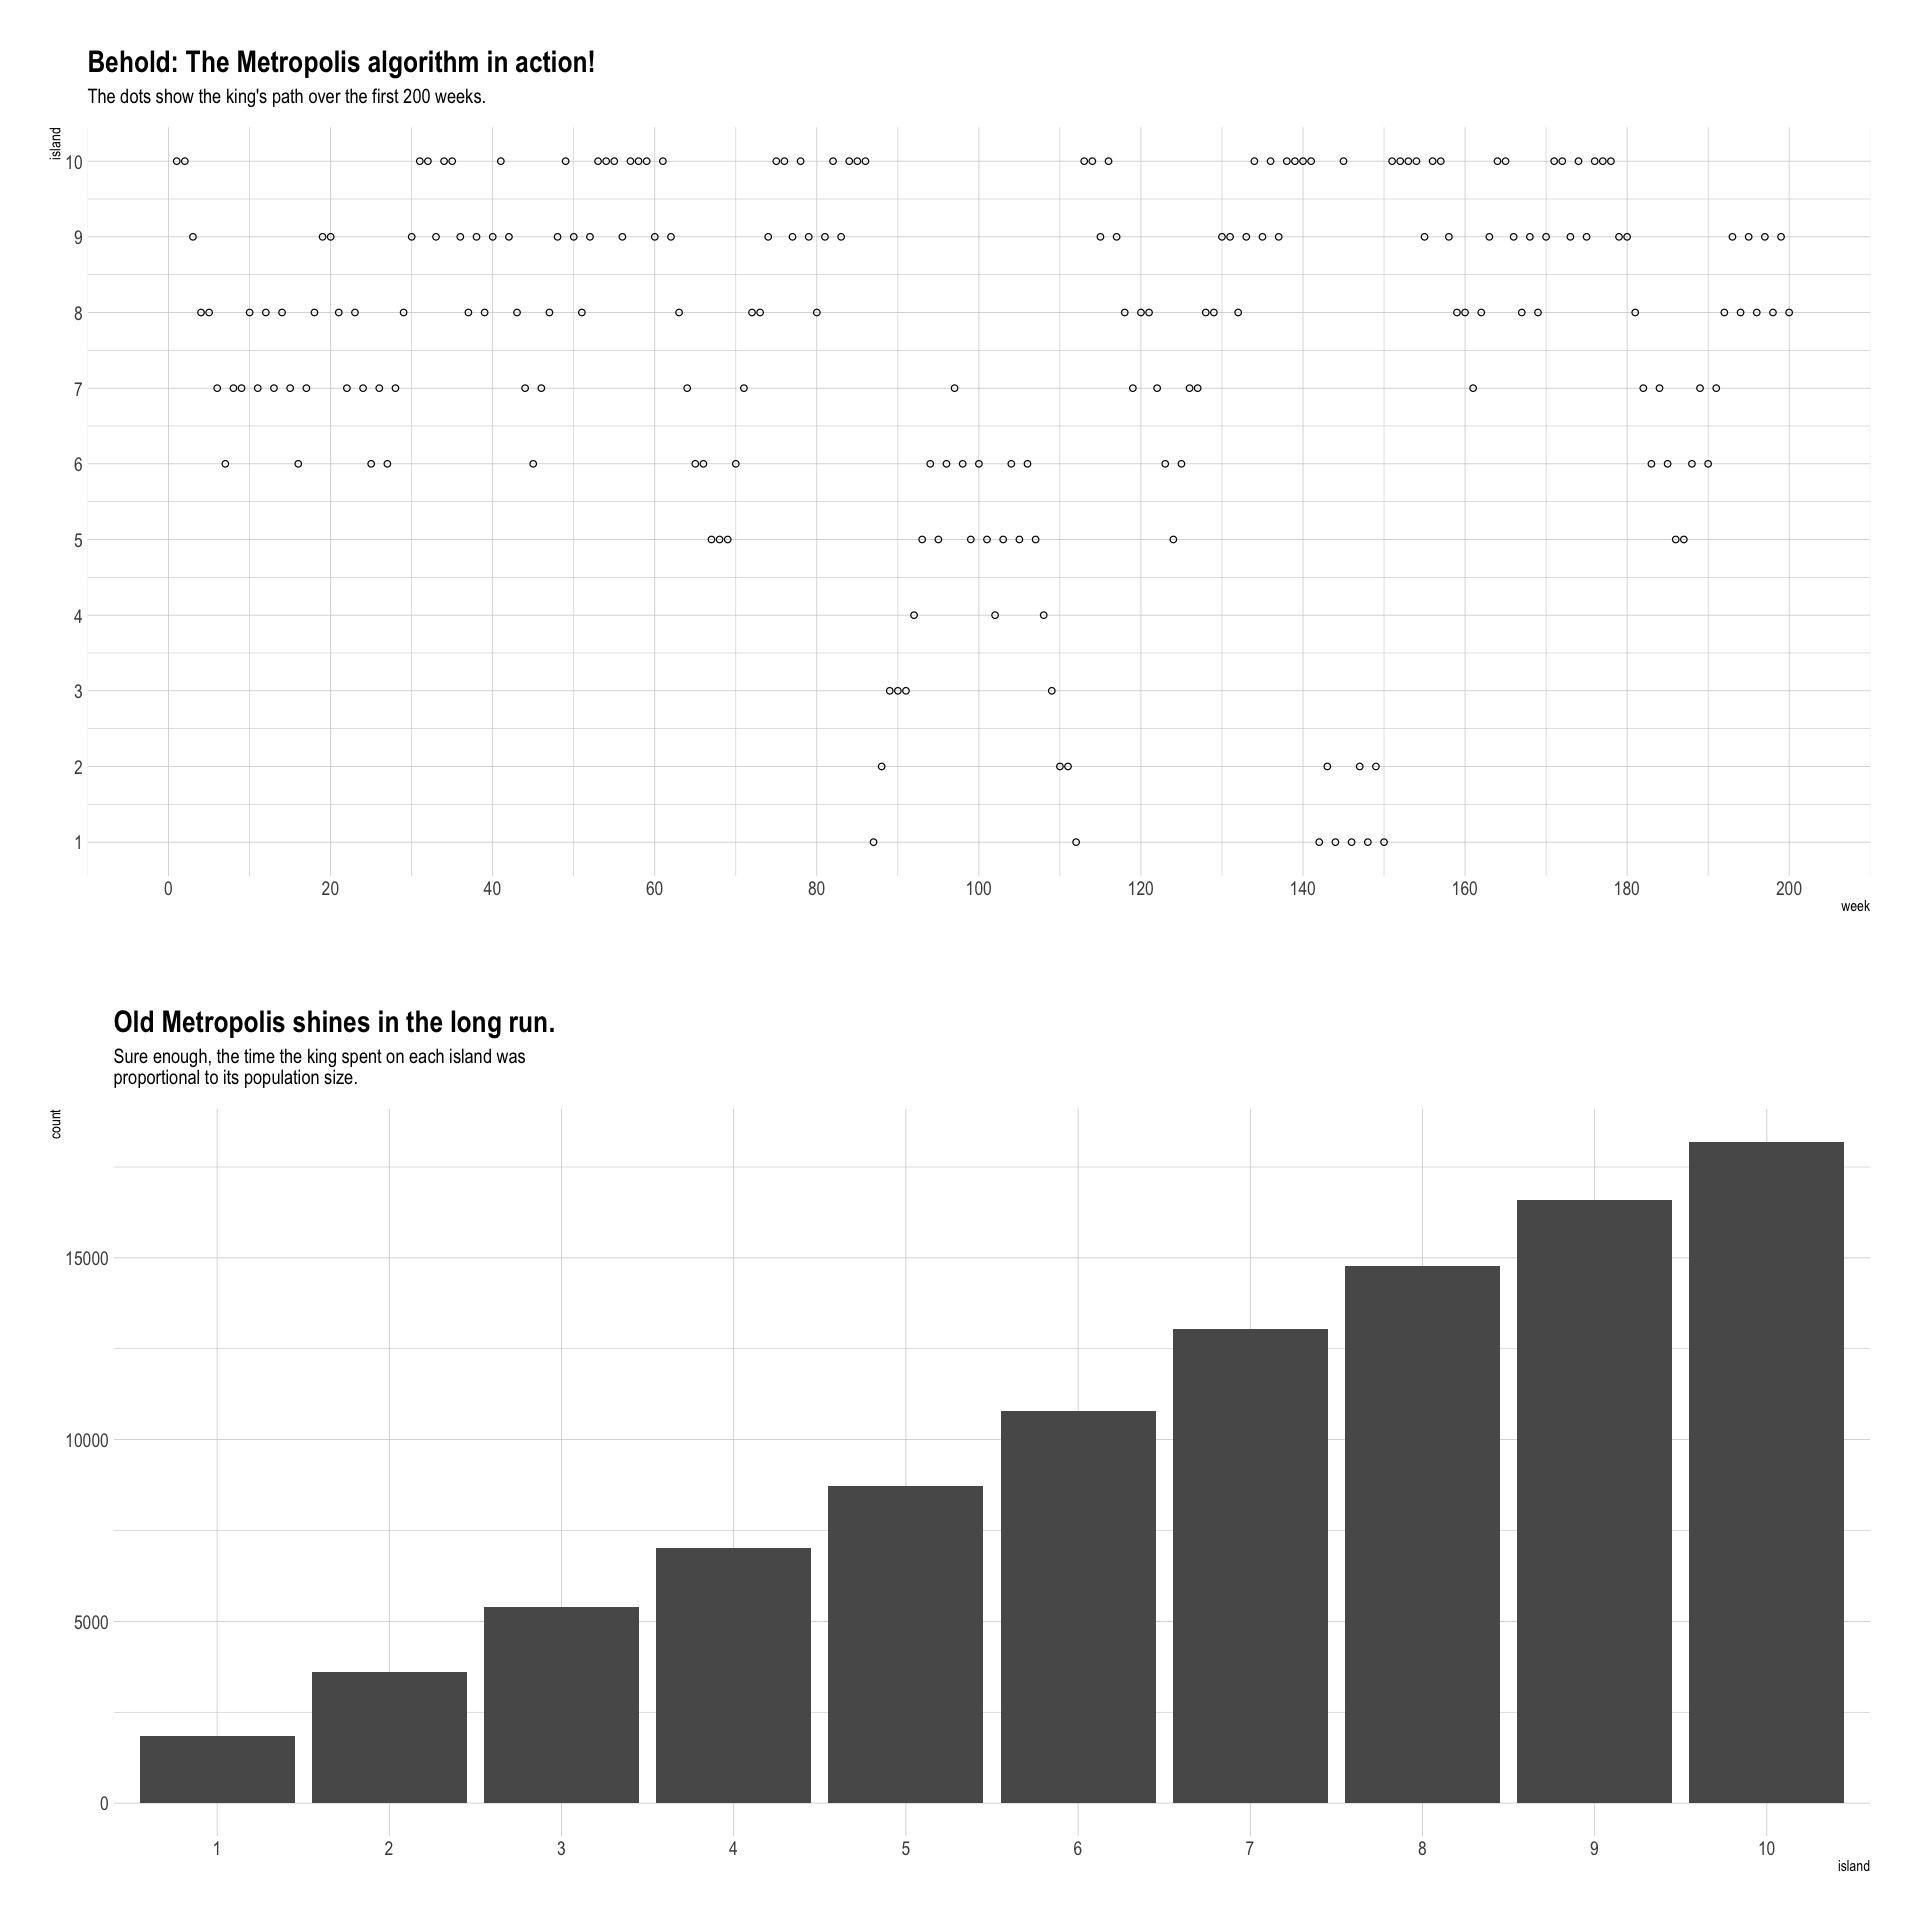

In [43]:
library(hrbrthemes)
library(tidyverse)

p1 = tibble(week   = 1:1e5,
       island = positions) %>%

  ggplot(aes(x = week, y = island)) +
  geom_point(shape = 1) +
  scale_x_continuous(limits = c(0, 200), breaks = seq(0, 200, 20)) +
  scale_y_continuous(limits = c(1, 10), breaks = seq(0, 10, 1)) +
  labs(title    = "Behold: The Metropolis algorithm in action!",
       subtitle = "The dots show the king's path over the first 200 weeks.") +
  theme_ipsum()

p2 = tibble(week   = 1:1e5,
       island = positions) %>%
  mutate(island = factor(island)) %>%

  ggplot(aes(x = island)) +
  geom_bar() +
  labs(title    = "Old Metropolis shines in the long run.",
       subtitle = "Sure enough, the time the king spent on each island was\nproportional to its population size.") +
  theme_ipsum()

cowplot::plot_grid(p1, p2, nrow = 2)

# HMC

In [25]:
library(rethinking)
data(rugged)
d <- rugged
detach(package:rethinking)
library(brms)
rm(rugged)

d <- 
  d %>%
  mutate(log_gdp = log(rgdppc_2000))

dd <-
  d %>%
  drop_na(rgdppc_2000)
head(dd)

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: parallel

Loading required package: dagitty

rethinking (Version 1.95)


Attaching package: ‘rethinking’


The following object is masked from ‘package:purrr’:

    map


The following object is masked from ‘package:stats’:

    rstudent


Loading required package: Rcpp

Loading 'brms' package (version 2.12.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘p

isocode isonum country              rugged rugged_popw rugged_slope
3  AGO      24    Angola               0.858  0.714        2.274      
5  ALB       8    Albania              3.427  1.597       10.451      
8  ARE     784    United Arab Emirates 0.769  0.316        2.112      
9  ARG      32    Argentina            0.775  0.220        2.268      
10 ARM      51    Armenia              2.688  0.934        8.178      
12 ATG      28    Antigua and Barbuda  0.006  0.003        0.012      
   rugged_lsd rugged_pc land_area lat     ⋯ africa_region_e africa_region_c
3  0.228       4.906    124670    -12.299 ⋯ 0               1              
5  1.006      62.133      2740     41.143 ⋯ 0               0              
8  0.191       6.142      8360     23.913 ⋯ 0               0              
9  0.226       9.407    273669    -35.396 ⋯ 0               0              
10 0.799      50.556      2820     40.294 ⋯ 0               0              
12 0.003       0.000        44     17.271 ⋯ 0               0              
   slave_exports dist_slavemkt_atlantic dist_slavemkt_indian
3  3610000       5.669                  6.981               
5        0          NA                     NA               
8        0          NA                     NA               
9        0          NA                     NA               
10       0          NA                     NA               
12       0          NA                     NA               
   dist_slavemkt_saharan dist_slavemkt_redsea pop_1400 european_descent
3  4.926                 3.872                1223208    2.000         
5     NA                    NA                 200000  100.000         
8     NA                    NA                  19200    0.000         
9     NA                    NA                 276632   89.889         
10    NA                    NA                 105743    0.500         
12    NA                    NA                    747       NA         
   log_gdp 
3  7.492609
5  8.216929
8  9.933263
9  9.407032
10 7.792343
12 9.212541

In [26]:
dd.trim <-
  dd %>%
  select(log_gdp, rugged, cont_africa)

str(dd.trim)

'data.frame':	170 obs. of  3 variables:
 $ log_gdp    : num  7.49 8.22 9.93 9.41 7.79 ...
 $ rugged     : num  0.858 3.427 0.769 0.775 2.688 ...
 $ cont_africa: int  1 0 0 0 0 0 0 0 0 1 ...


In [27]:
b8.1 <-
  brm(data = dd, family = gaussian,
      log_gdp ~ 1 + rugged + cont_africa + rugged:cont_africa,   #考虑交互项
      prior = c(prior(normal(0, 100), class = Intercept),
                prior(normal(0, 10), class = b),
                prior(cauchy(0, 2), class = sigma)),             #半柯西分布
      seed = 8)

print(b8.1)

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '7800258486a6dfd09b501505ab8f8544' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.0482 seconds (Warm-up)
Chain 1:                0.04405 seconds (Sampling)
Chain 

`rethinking::precis()`在汇总`map2stan()`模型时，McElreath的返回最高后验密度间隔`HPDI`。对于`brms`并非如此。如果需要`HPDI`，则必须使用`tidybayes`软件包中的便捷功能

In [59]:
library(tidybayes)

post <- posterior_samples(b8.1)

t(post %>% 
  gather() %>% 
  group_by(key) %>% 
  mean_hdi(value, .width = .95))  # note our rare use of 95% intervals, transpot

[,1]          [,2]         [,3]         [,4]                
key       b_cont_africa b_Intercept  b_rugged     b_rugged:cont_africa
value       -1.9466203     9.2251717   -0.2028492    0.3911221        
.lower      -2.3616656     8.9481774   -0.3561788    0.1349278        
.upper      -1.4899551     9.5121666   -0.0466529    0.6566371        
.width    0.95          0.95         0.95         0.95                
.point    mean          mean         mean         mean                
.interval hdi           hdi          hdi          hdi                 
          [,5]         [,6]        
key       lp__         sigma       
value     -248.5389181    0.9501693
.lower    -251.7007214    0.8535296
.upper    -246.1224171    1.0552463
.width    0.95         0.95        
.point    mean         mean        
.interval hdi          hdi

## 并行采样

In [47]:
b8.1_4chains_4cores <- 
  update(b8.1, 
         cores = 4)

print(b8.1_4chains_4cores)

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log_gdp ~ 1 + rugged + cont_africa + rugged:cont_africa 
   Data: dd (Number of observations: 170) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
                   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept              9.22      0.14     8.94     9.50 1.00     2760     3062
rugged                -0.20      0.08    -0.35    -0.05 1.00     2650     2913
cont_africa           -1.95      0.23    -2.40    -1.52 1.00     2577     2817
rugged:cont_africa     0.39      0.13     0.14     0.65 1.00     2410     2412

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.95      0.05     0.85     1.06 1.00     4077     3079

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the 

In [31]:
post <- posterior_samples(b8.1)
str(post)

'data.frame':	4000 obs. of  6 variables:
 $ b_Intercept         : num  9.31 9.14 9.07 9.1 9.21 ...
 $ b_rugged            : num  -0.27 -0.205 -0.256 -0.194 -0.223 ...
 $ b_cont_africa       : num  -2.14 -2.19 -1.87 -1.85 -2 ...
 $ b_rugged:cont_africa: num  0.554 0.48 0.404 0.412 0.395 ...
 $ sigma               : num  0.931 0.942 0.946 0.899 0.996 ...
 $ lp__                : num  -247 -248 -250 -247 -247 ...


## 可视化

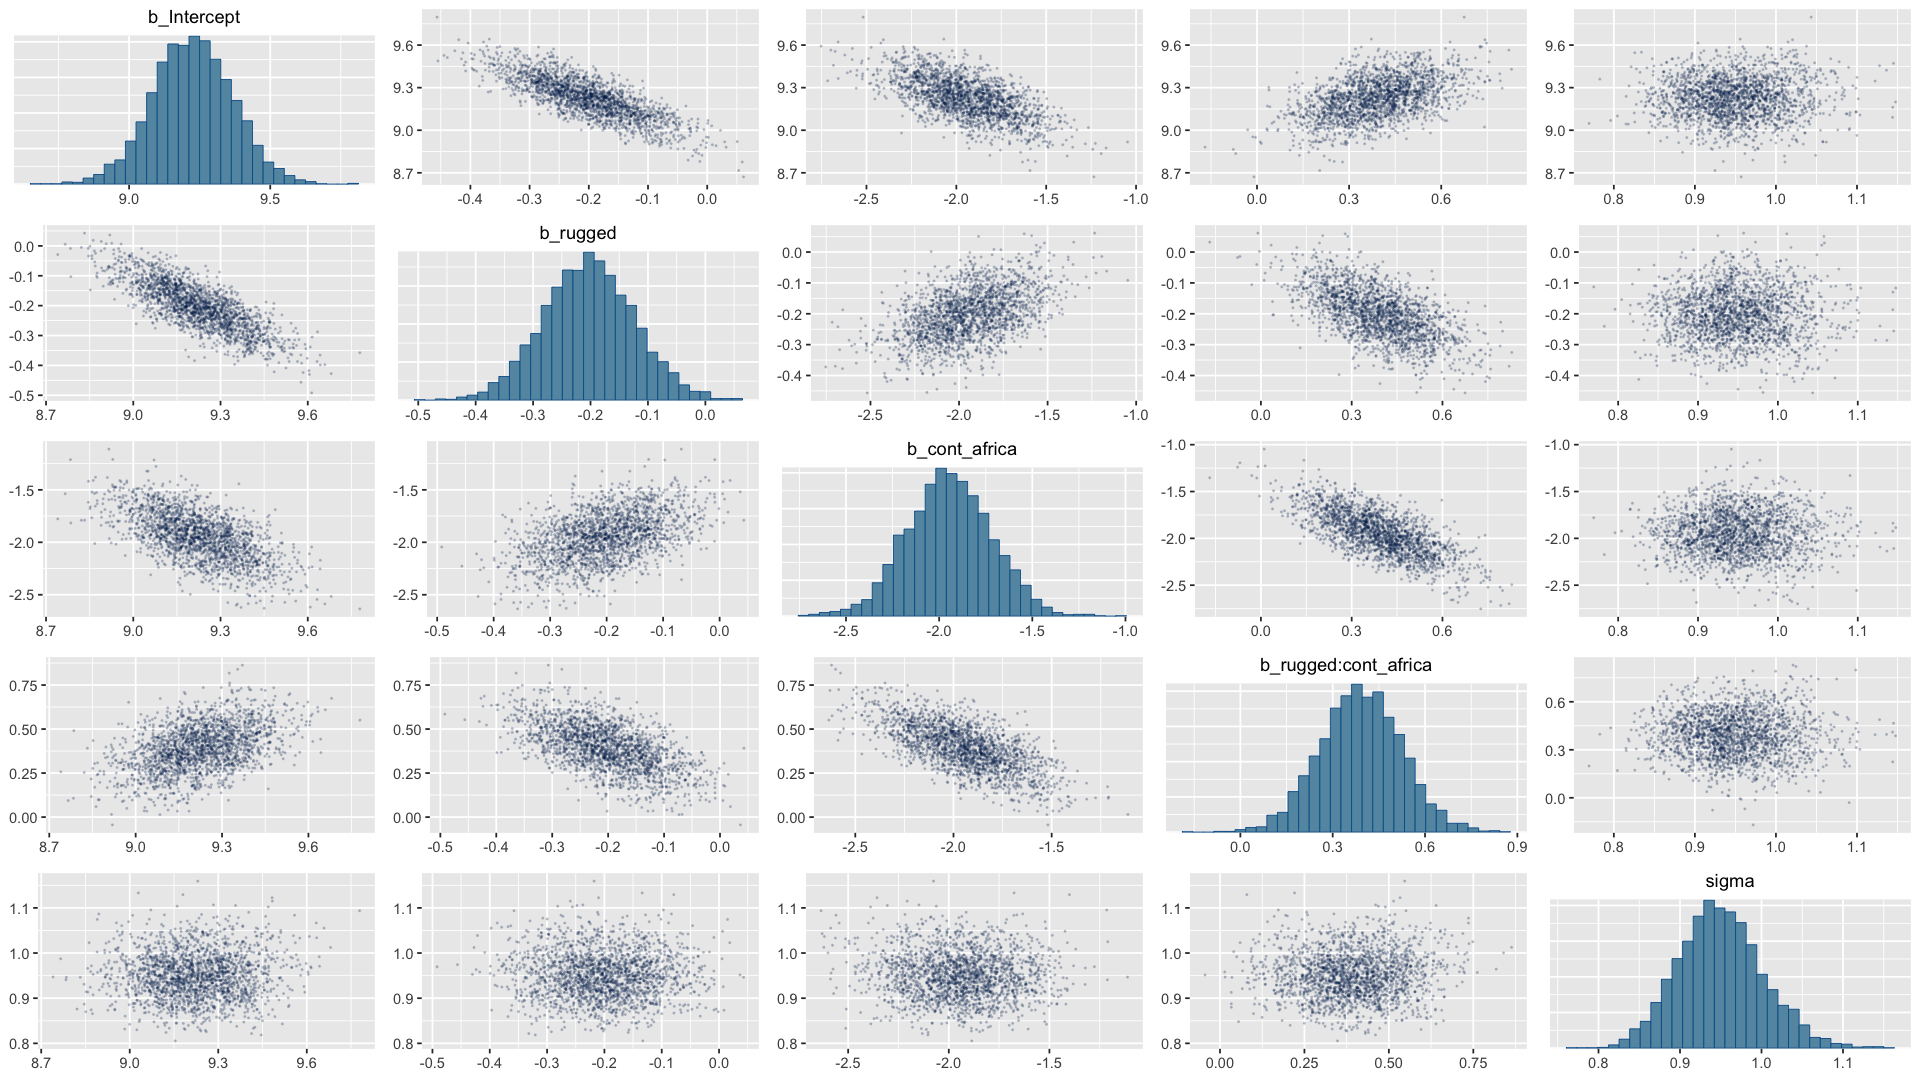

In [48]:
pairs(b8.1,
      off_diag_args = list(size = 1/5, alpha = 1/5))

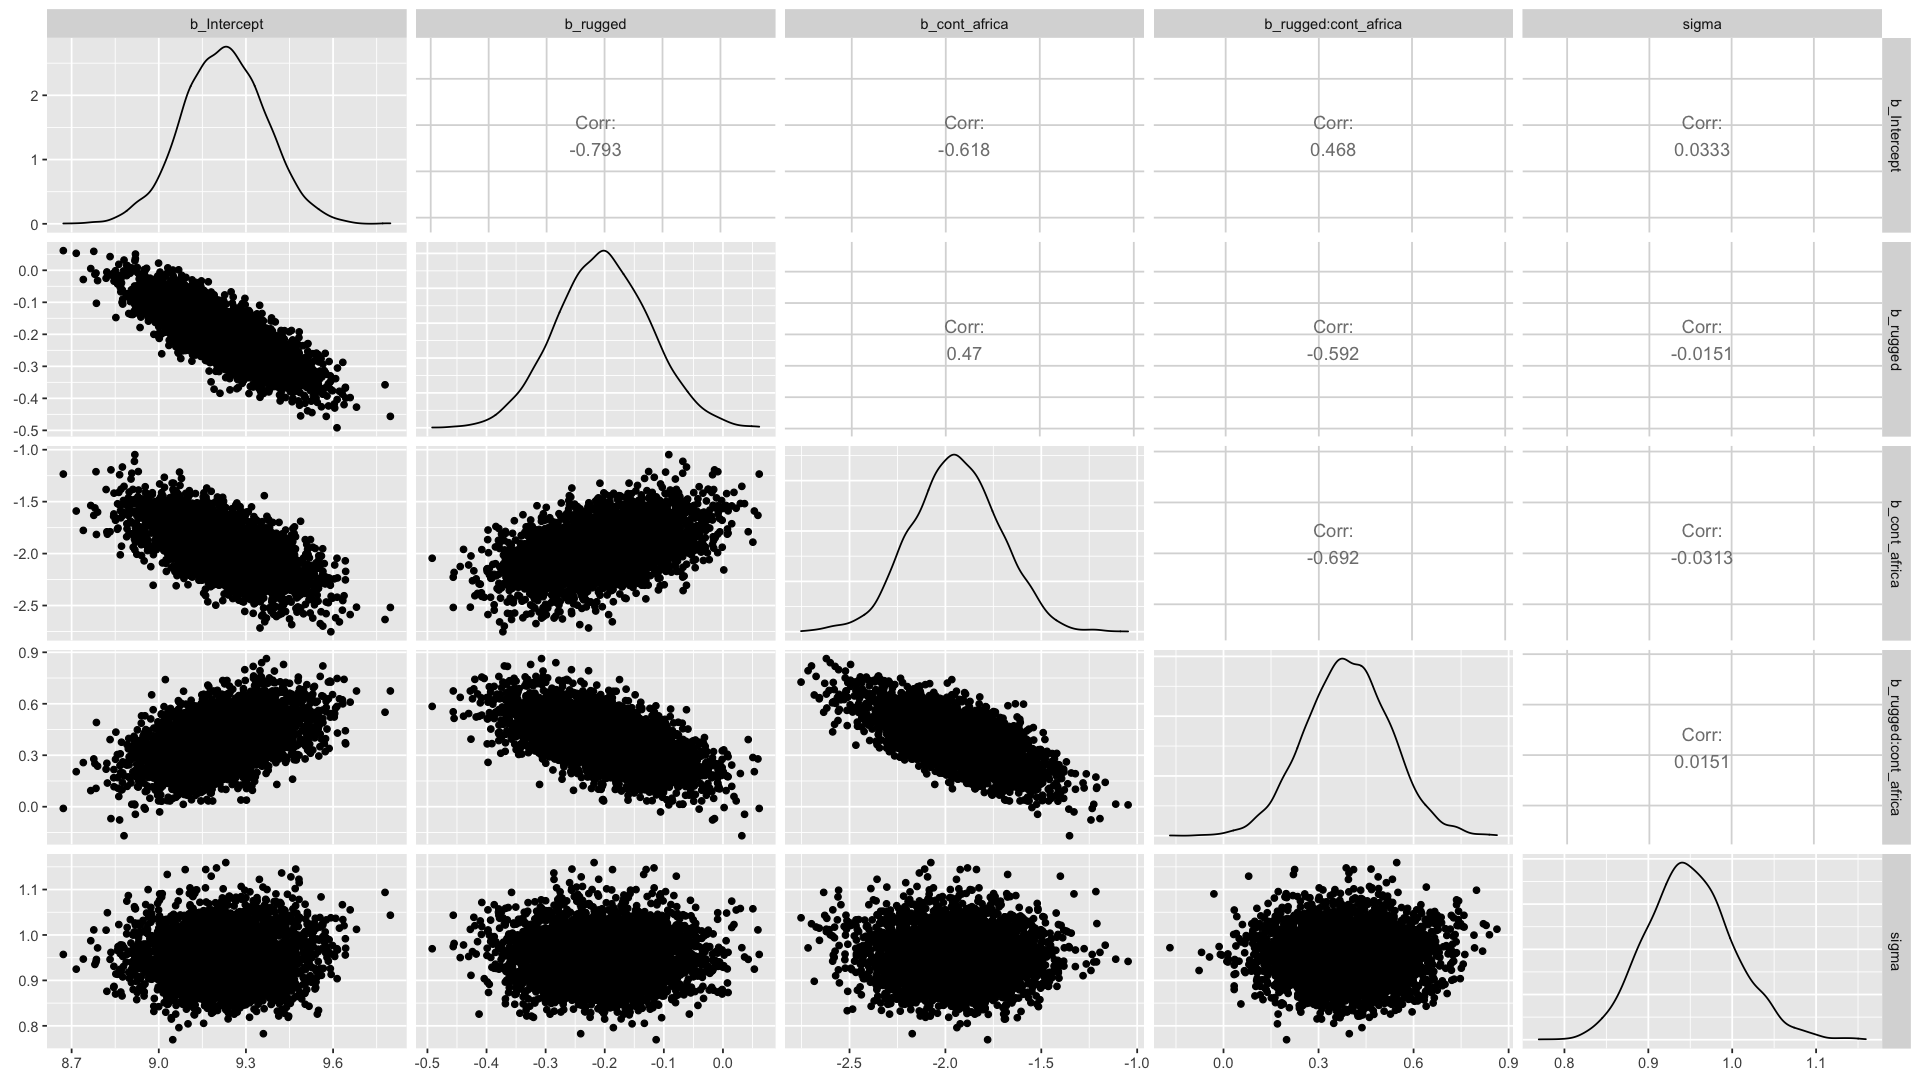

In [46]:
library(GGally)
post %>%
  select(b_Intercept:sigma) %>%
  ggpairs()

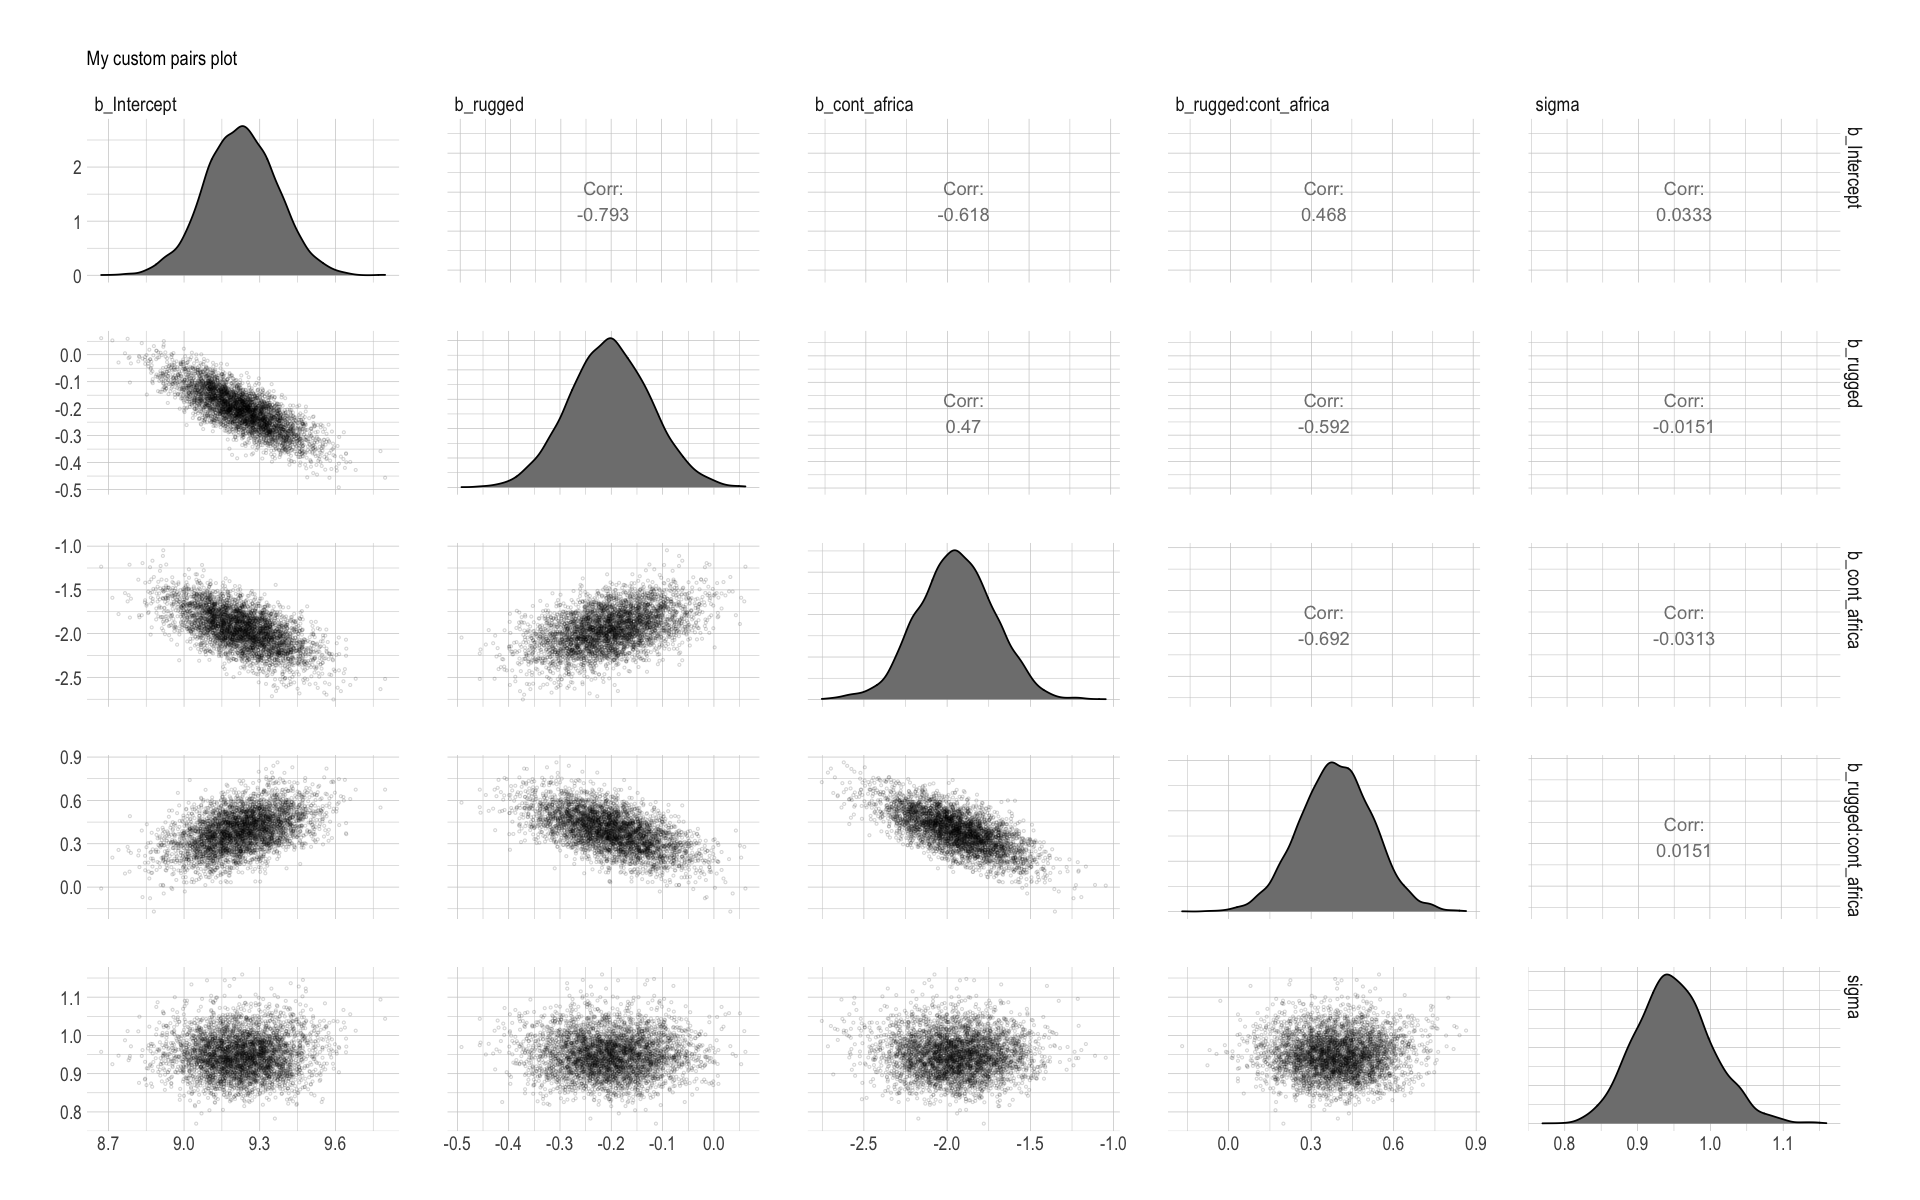

In [41]:
my_diag <- function(data, mapping, ...){
  ggplot(data = data, mapping = mapping) + 
    geom_density(fill = "grey50")
}

my_lower <- function(data, mapping, ...){
  ggplot(data = data, mapping = mapping) + 
    geom_point(shape = 1, size = 1/2, alpha = 1/6)
  }

post %>%
  select(b_Intercept:sigma) %>%

  ggpairs(diag  = list(continuous = my_diag),
          lower = list(continuous = my_lower)) +
  labs(subtitle = "My custom pairs plot") +
  theme_ipsum()

## 使用样本

In [49]:
summary(b8.1, loo = T, waic = T)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log_gdp ~ 1 + rugged + cont_africa + rugged:cont_africa 
   Data: dd (Number of observations: 170) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
                   Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept              9.23      0.14     8.94     9.51 1.00     3351     3290
rugged                -0.20      0.08    -0.36    -0.05 1.00     3375     3389
cont_africa           -1.95      0.23    -2.40    -1.51 1.00     3008     3101
rugged:cont_africa     0.39      0.13     0.13     0.65 1.00     2854     3320

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.95      0.05     0.85     1.06 1.00     4355     2577

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the 

In [50]:
waic(b8.1)


Computed from 4000 by 170 log-likelihood matrix

          Estimate   SE
elpd_waic   -234.7  7.4
p_waic         5.1  0.9
waic         469.3 14.8

2 (1.2%) p_waic estimates greater than 0.4. We recommend trying loo instead. 

In [54]:
loo(b8.1)


Computed from 4000 by 170 log-likelihood matrix

         Estimate   SE
elpd_loo   -234.7  7.4
p_loo         5.2  0.9
looic       469.5 14.9
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

The `elpd` values returned by `loo()` and `waic()` are the expected log pointwise predictive density for new data:  
$$\mathrm{elpd}=\sum_{i=1}^{n} \int p_{t}\left(\tilde{y}_{i}\right) \log p\left(\tilde{y}_{i} | y\right) d \tilde{y}_{i}$$
- $p_{t}\left(\tilde{y}_{i}\right)$代表用于表征关于$\tilde{y}_{i}$的真实数据生成过程的分布，其本身未知，会使用留一法或WAIC进行近似；
- 在回归中，这些分布也隐含地以模型中的任何预测变量为条件  
`elpd_loo `：Bayesian LOO estimate of out-of-sample predictive fit is defined as:  
$$\operatorname{elpd}_{\mathrm{loo}}=\sum_{i=1}^{n} \log p\left(y_{i} | y-_{i}\right)$$  
此处$p\left(y_{i} | y-_{i}\right)=\int p\left(y_{i} | \theta\right) p\left(\theta | y-_{i}\right) d \theta$，代表给定不含第i个数据点下的`loo`预测密度

## 检查预测链

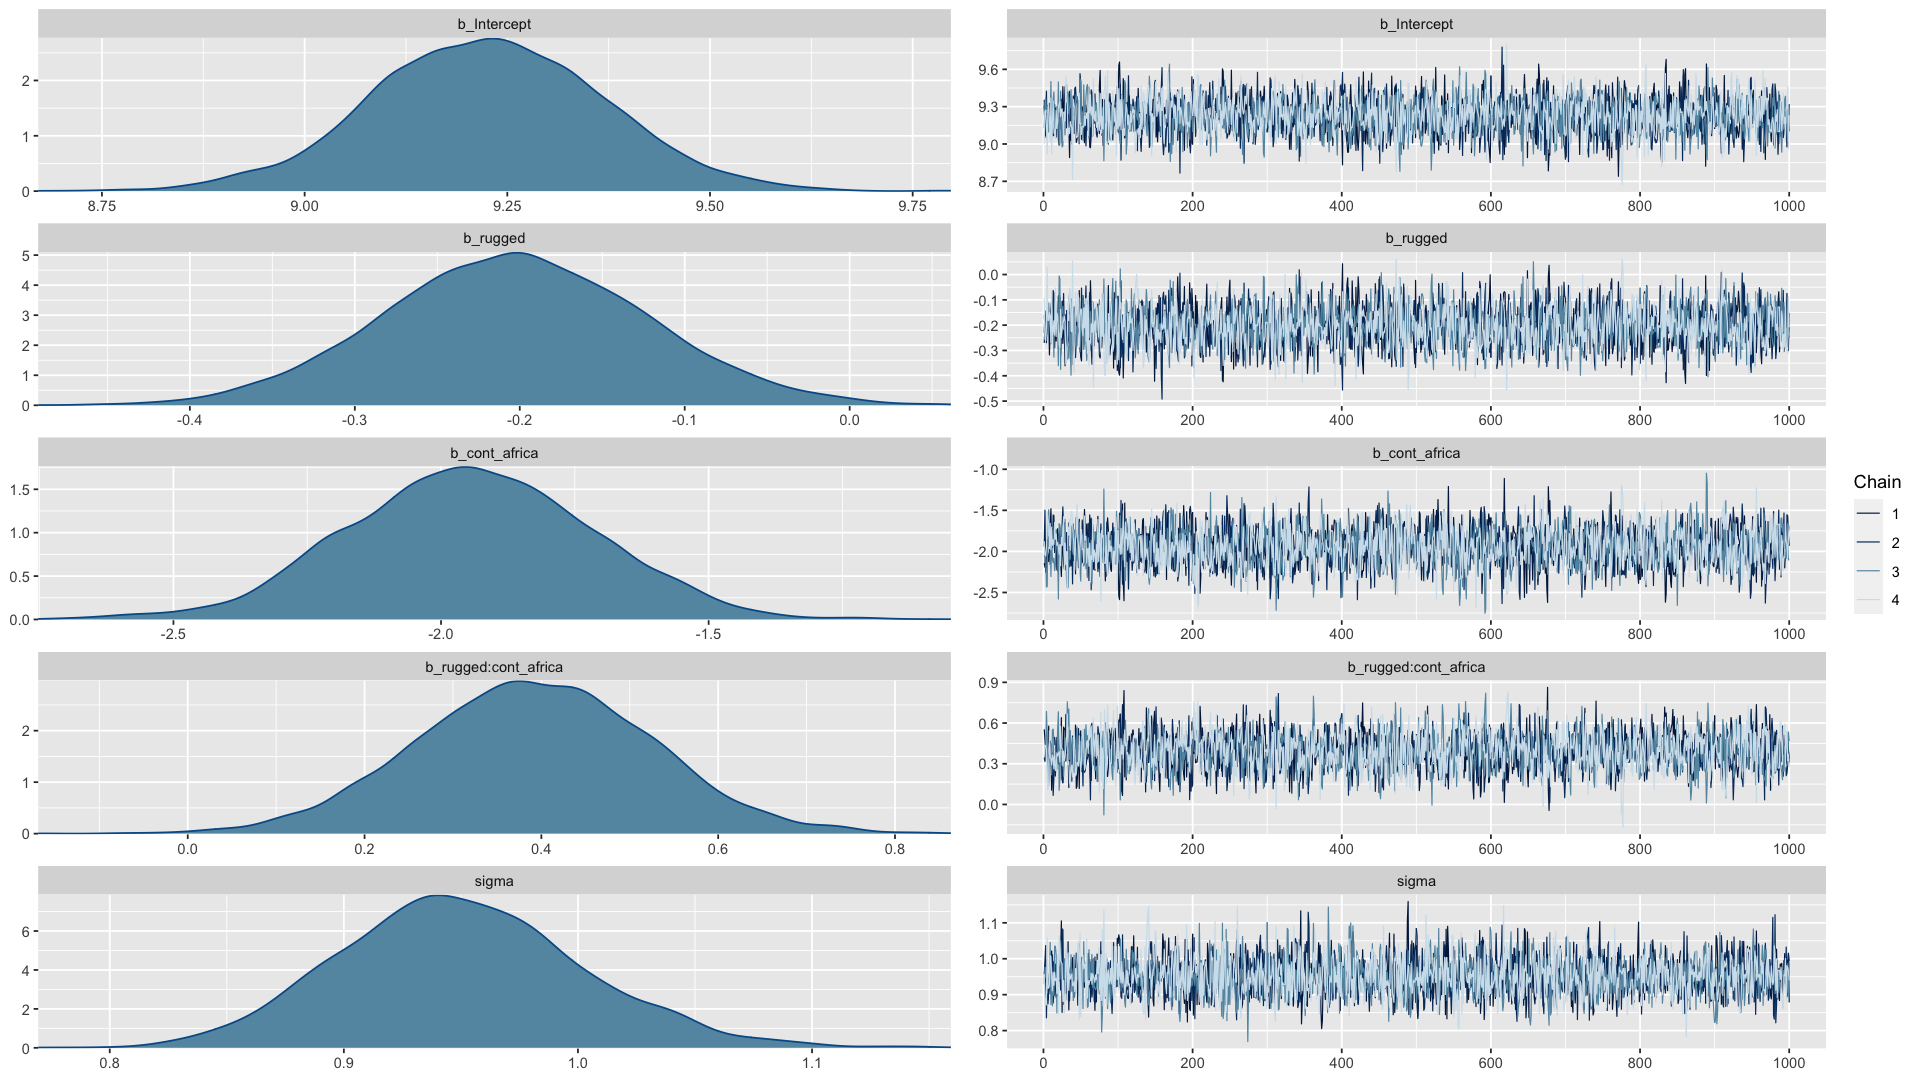

In [55]:
plot(b8.1)

This is bayesplot version 1.7.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



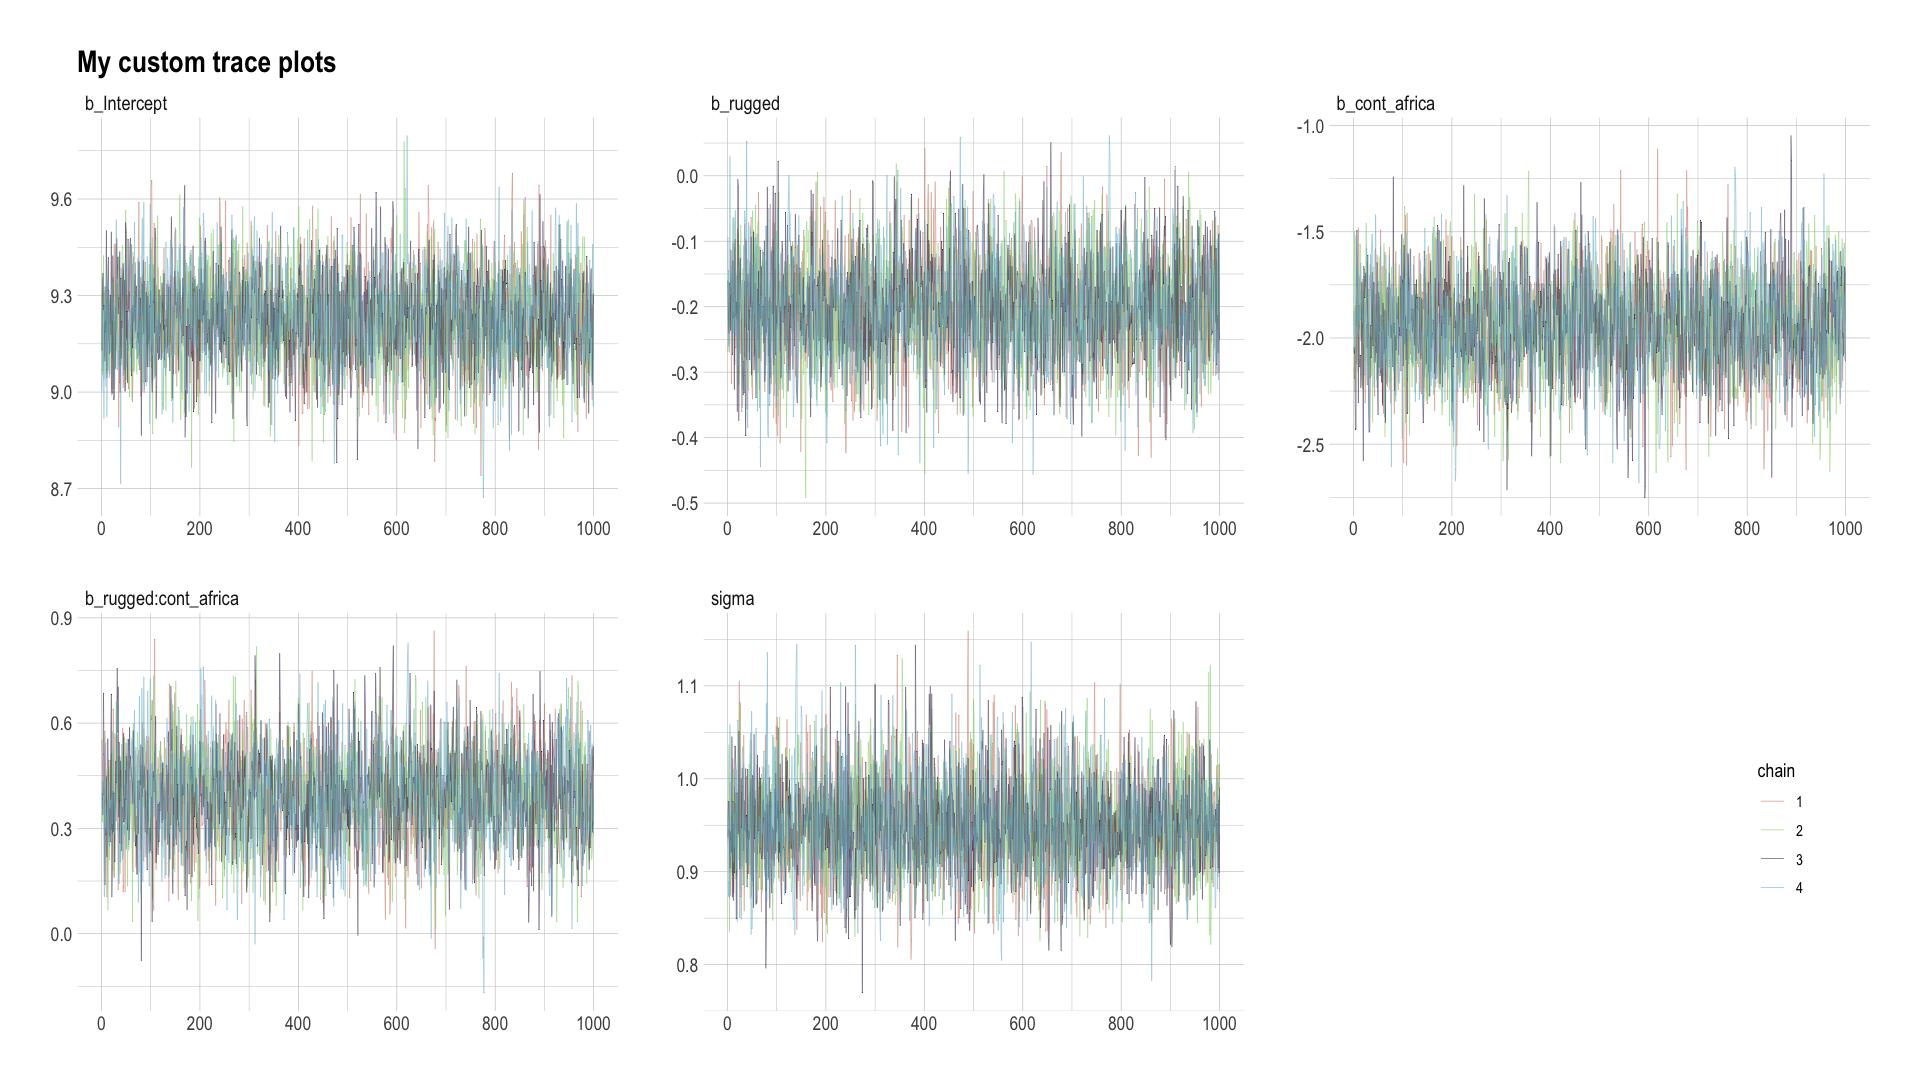

In [56]:
library(bayesplot)

post <- posterior_samples(b8.1, add_chain = T)

mcmc_trace(post[, c(1:5, 7)],  # we need to include column 7 because it contains the chain info 
           facet_args = list(ncol = 3), 
           size = .15) +
  labs(title = "My custom trace plots") +
  scale_color_ipsum() +
  theme_ipsum() +
  theme(legend.position = c(.95, .2))

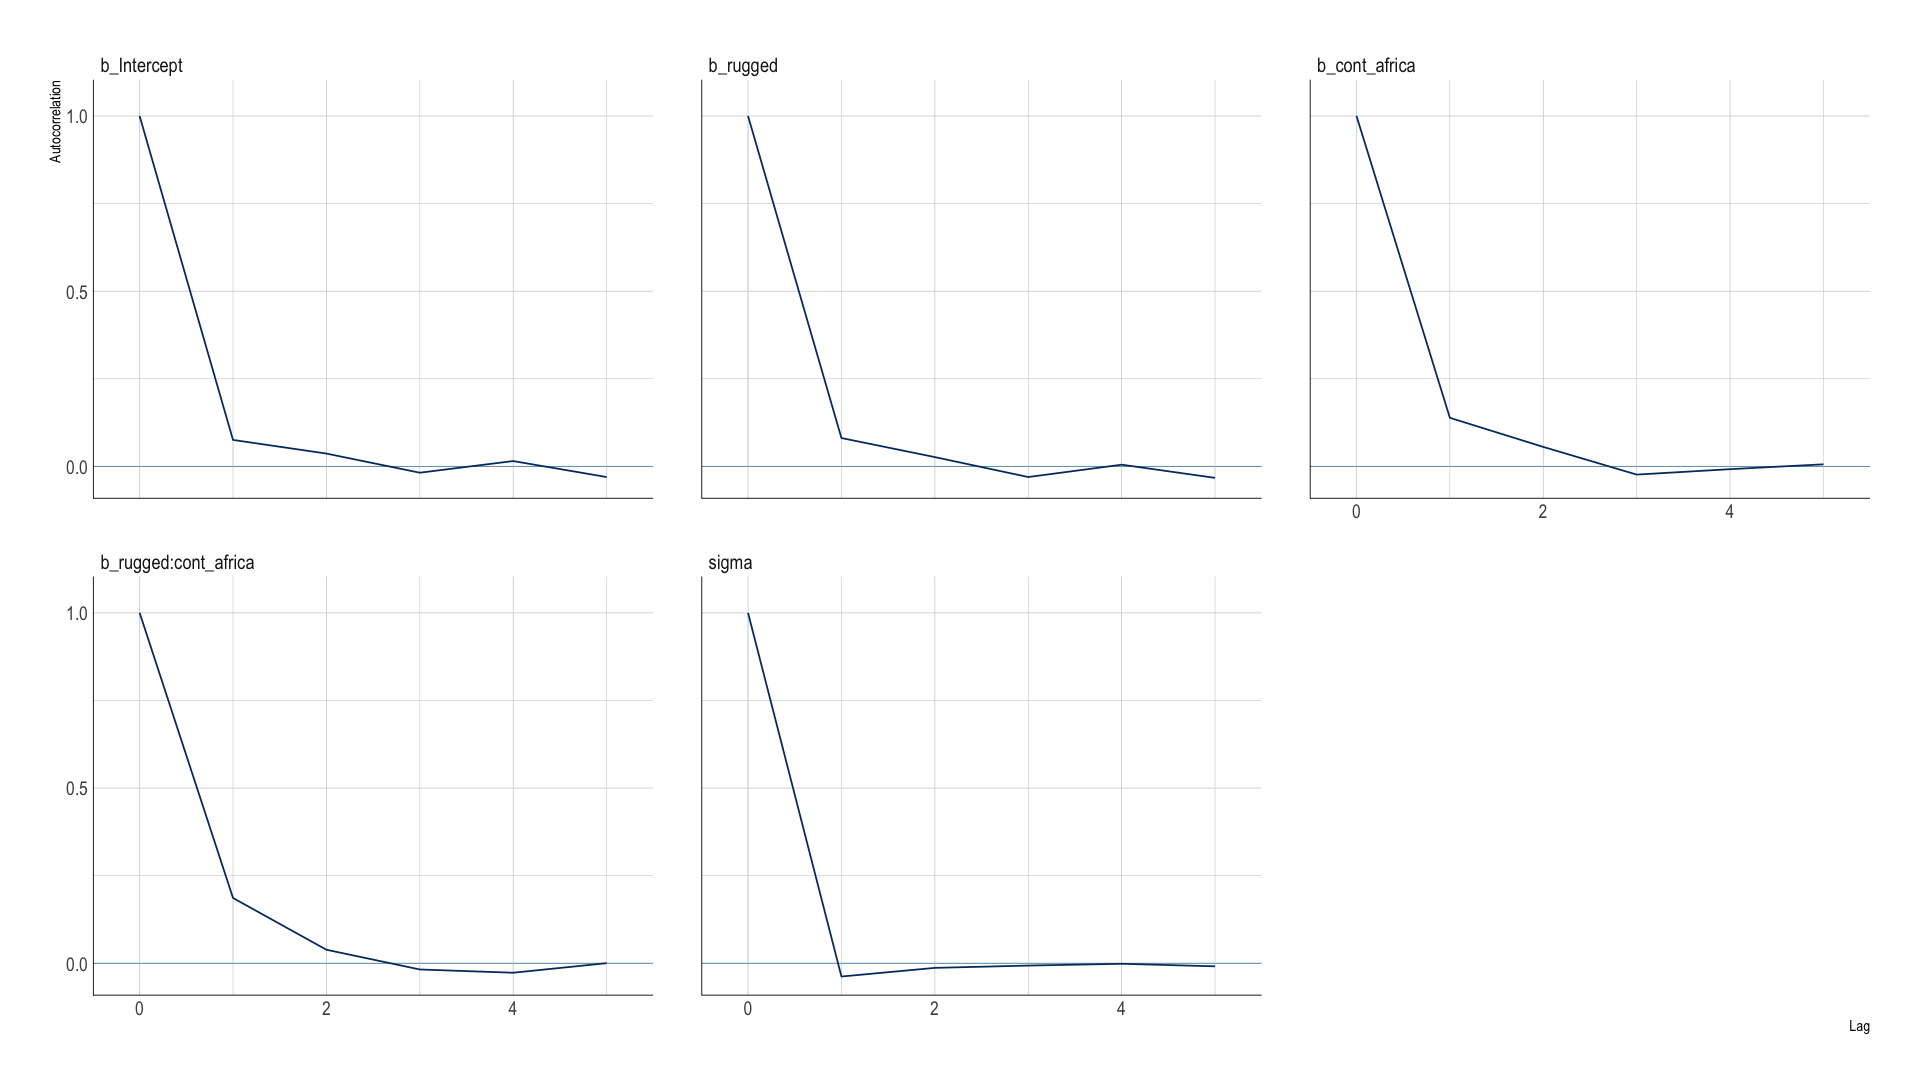

In [62]:
mcmc_acf(post, 
         pars = c("b_Intercept", "b_rugged", "b_cont_africa", "b_rugged:cont_africa", "sigma"),
         lags = 5) +
  scale_color_ipsum() +
  theme_ipsum()

## 查看模型语法

In [63]:
brms::stancode(b8.1)

// generated with brms 2.12.0
functions {
}
data {
  int<lower=1> N;  // number of observations
  vector[N] Y;  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
  int Kc = K - 1;
  matrix[N, Kc] Xc;  // centered version of X without an intercept
  vector[Kc] means_X;  // column means of X before centering
  for (i in 2:K) {
    means_X[i - 1] = mean(X[, i]);
    Xc[, i - 1] = X[, i] - means_X[i - 1];
  }
}
parameters {
  vector[Kc] b;  // population-level effects
  real Intercept;  // temporary intercept for centered predictors
  real<lower=0> sigma;  // residual SD
}
transformed parameters {
}
model {
  // priors including all constants
  target += normal_lpdf(b | 0, 10);
  target += normal_lpdf(Intercept | 0, 100);
  target += cauchy_lpdf(sigma | 0, 2)
    - 1 * cauchy_lccdf(0 | 0, 2);
  // likelihood including all constants
  if (!prior_only) {
    target += normal_id_glm_lpdf(Y | Xc, Intercept, b, sigma);
  }
}
generated quantities {
  // actual population-level intercept
  real b_Intercept = Intercept - dot_product(means_X, b);
}

In [66]:
b8.1_4chains_4cores$model

// generated with brms 2.12.0
functions {
}
data {
  int<lower=1> N;  // number of observations
  vector[N] Y;  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
  int Kc = K - 1;
  matrix[N, Kc] Xc;  // centered version of X without an intercept
  vector[Kc] means_X;  // column means of X before centering
  for (i in 2:K) {
    means_X[i - 1] = mean(X[, i]);
    Xc[, i - 1] = X[, i] - means_X[i - 1];
  }
}
parameters {
  vector[Kc] b;  // population-level effects
  real Intercept;  // temporary intercept for centered predictors
  real<lower=0> sigma;  // residual SD
}
transformed parameters {
}
model {
  // priors including all constants
  target += normal_lpdf(b | 0, 10);
  target += normal_lpdf(Intercept | 0, 100);
  target += cauchy_lpdf(sigma | 0, 2)
    - 1 * cauchy_lccdf(0 | 0, 2);
  // likelihood including all constants
  if (!prior_only) {
    target += normal_id_glm_lpdf(Y | Xc, Intercept, b, sigma);
  }
}
generated quantities {
  // actual population-level intercept
  real b_Intercept = Intercept - dot_product(means_X, b);
}

In [65]:
b8.1$fit@stanmodel

S4 class stanmodel '7800258486a6dfd09b501505ab8f8544' coded as follows:
// generated with brms 2.12.0
functions {
}
data {
  int<lower=1> N;  // number of observations
  vector[N] Y;  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
  int Kc = K - 1;
  matrix[N, Kc] Xc;  // centered version of X without an intercept
  vector[Kc] means_X;  // column means of X before centering
  for (i in 2:K) {
    means_X[i - 1] = mean(X[, i]);
    Xc[, i - 1] = X[, i] - means_X[i - 1];
  }
}
parameters {
  vector[Kc] b;  // population-level effects
  real Intercept;  // temporary intercept for centered predictors
  real<lower=0> sigma;  // residual SD
}
transformed parameters {
}
model {
  // priors including all constants
  target += normal_lpdf(b | 0, 10);
  target += normal_lpdf(Intercept | 0, 100);
  target += cauchy_lpdf(sigma | 0, 2)
    

# 调试错误的马尔科夫链

brms defaults for `iter` and `warmup` match those of McElreath’s `rethinking`

## 水平先验

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '1f9a5ae7137ffb65206d4772ccb6f8f2' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 4000 [ 25%]  (Sampling)
Chain 1: Iteration: 1400 / 4000 [ 35%]  (Sampling)
Chain 1: Iteration: 1800 / 4000 [ 45%]  (Sampling)
Chain 1: Iteration: 2200 / 4000 [ 55%]  (Sampling)
Chain 1: Iteration: 2600 / 4000 [ 65%]  (Sampling)
Chain 1: Iteration: 3000 / 4000 [ 75%]  (Sampling)
Chain 1: Iteration: 3400 / 4000 [ 85%]  (Sampling)
Chain 1: Iteration: 3800 / 4000 [ 95%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.061772 seconds (Warm-up)
Chain 1:                1.54 seconds (Sampling

Warning message:
“There were 1181 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 199 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.35, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/

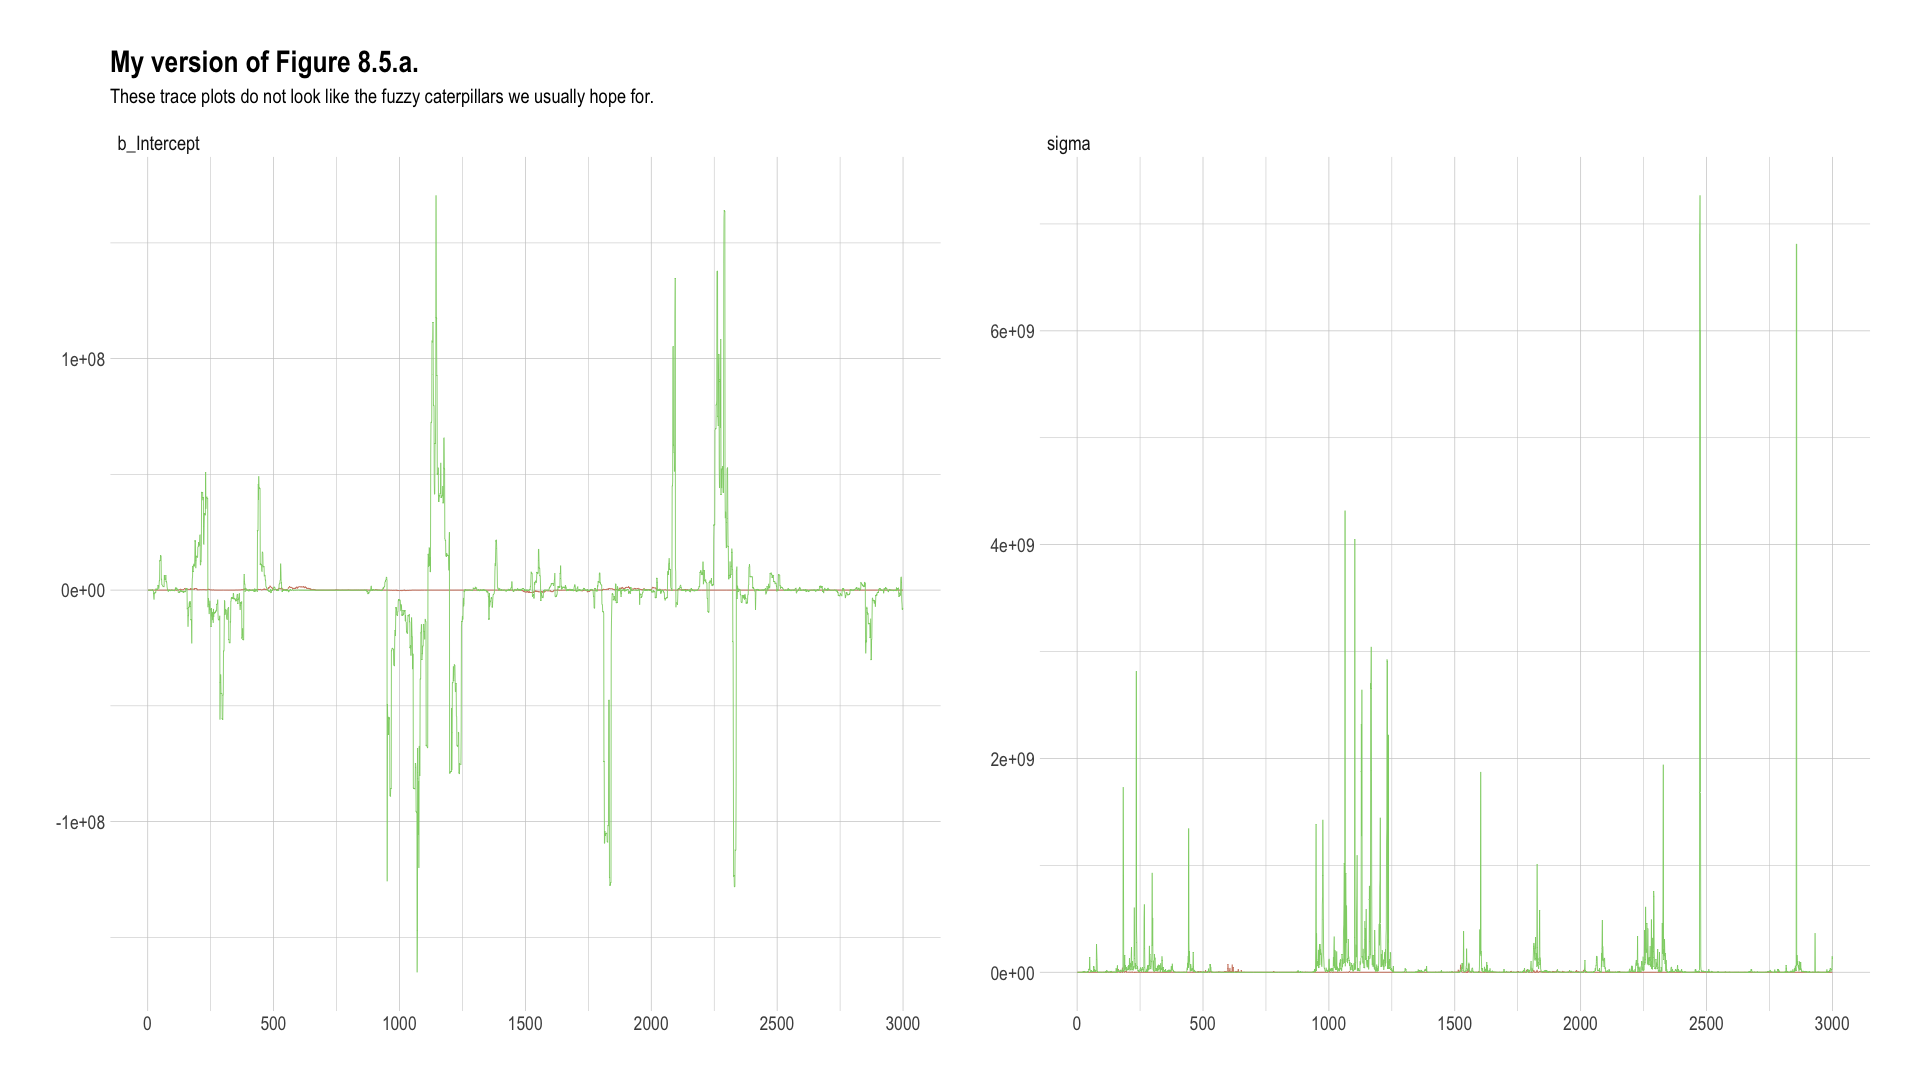

In [68]:
b8.2 <-
  brm(data = list(y = c(-1, 1)), 
      family = gaussian,
      y ~ 1,
      prior = c(prior(uniform(-1e10, 1e10), class = Intercept),
                prior(uniform(0, 1e10), class = sigma)),
      inits = list(list(Intercept = 0, sigma = 1),
                   list(Intercept = 0, sigma = 1)),
      iter = 4000, warmup = 1000, chains = 2,
      seed = 8)

#估计两个服从高斯分布的观测（1 和-1) 对应的标准差，使用不太好的水平先验

post <- posterior_samples(b8.2, add_chain = T)

mcmc_trace(post[, c(1:2, 4)],
           size = .25) +
  labs(title    = "My version of Figure 8.5.a.",
       subtitle = "These trace plots do not look like the fuzzy caterpillars we usually hope for.") +
  scale_color_ipsum() +
  theme_ipsum() +
  theme(legend.position = c(.85, 1.5),
        legend.direction = "horizontal")

这样的估计不可能是对的。-1 和 1 的平均是 0, 因此α的均值应该在 0 附近。相反，这里得到的估计大得离谱，置信区间也很宽。σ的估计也好不到哪去。你还可以看到，诊断度量也表明结果并不可靠。有效样本数目 neff 很小，而且对于健康的马氏链，$\hat{R}$应该接近 1, 即使取值是 1.01 也是很可疑的，更不用说这里的$\hat{R}$是 1.35, 简直是个灾难。  
根据上图可知，得到这么诡异的估计是因为马尔可夫链在参数取值区域内漫无目的地游走，时不时还在极端取值附近逗留一阵。这不是平稳的链条，这样的过程不能给出有用的样本

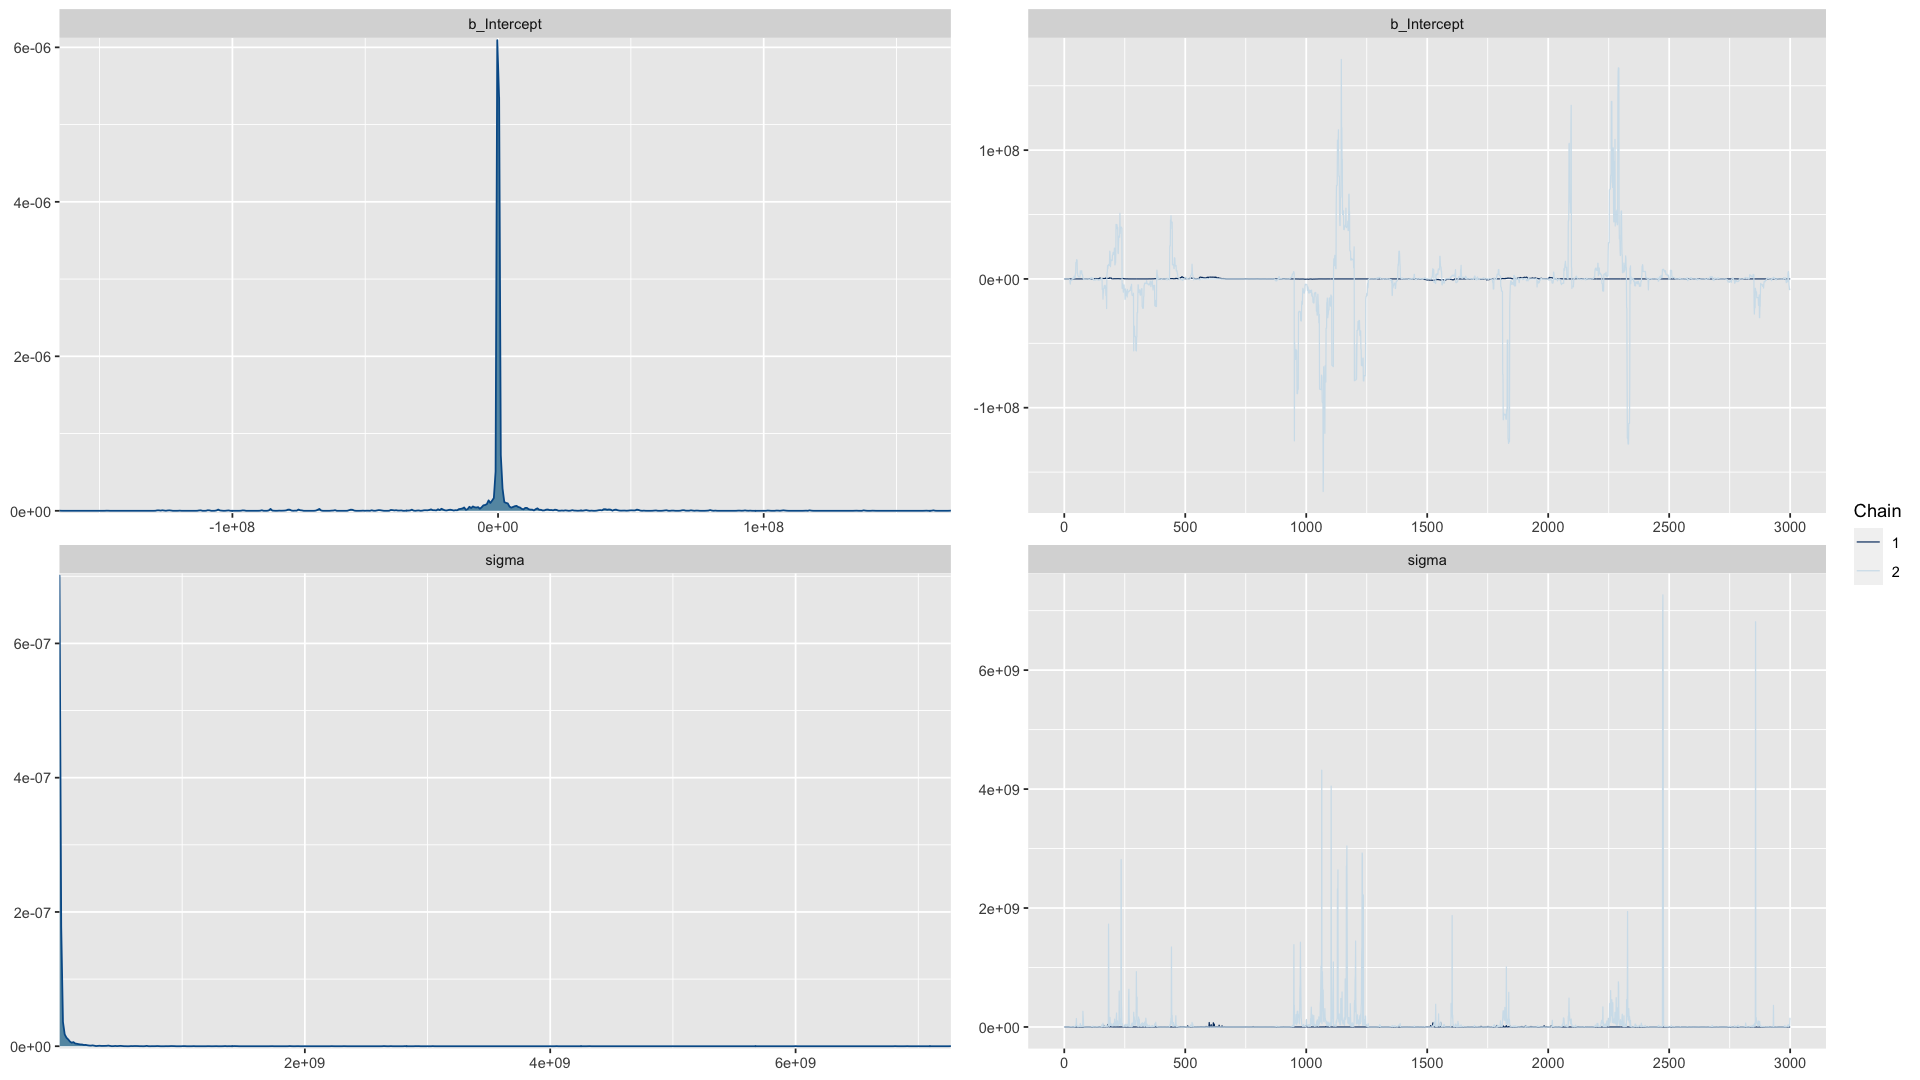

In [72]:
plot(b8.2)

In [69]:
print(b8.2)

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”
Warning message:
“There were 1181 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: y ~ 1 
   Data: list(y = c(-1, 1)) (Number of observations: 2) 
Samples: 2 chains, each with iter = 4000; warmup = 1000; thin = 1;
         total post-warmup samples = 6000

Population-Level Effects: 
            Estimate   Est.Error     l-95% CI    u-95% CI Rhat Bulk_ESS
Intercept -604157.57 17876182.27 -36678975.50 28140367.73 1.35      125
          Tail_ESS
Intercept       62

Family Specific Parameters: 
         Estimate    Est.Error l-95% CI     u-95% CI Rhat Bulk_ESS Tail_ESS
sigma 28839644.97 236523573.15    19.63 182964998.41 1.33        5       19

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


## 半柯西先验
\begin{array}{l}y_{i} \sim \operatorname{Normal}(\mu, \sigma) \\ \mu=\alpha \\ \alpha \sim \operatorname{Normal}(1,10) \\ \sigma \sim \text { HalfCauchy }(0,1)\end{array}

In [70]:
b8.3 <-
  brm(data = list(y = c(-1, 1)), 
      family = gaussian,
      y ~ 1,
      prior = c(prior(normal(0, 10), class = Intercept),
                prior(cauchy(0, 1), class = sigma)),
      inits = list(list(Intercept = 0, sigma = 1),
                   list(Intercept = 0, sigma = 1)),
      iter = 4000, warmup = 1000, chains = 2,
      seed = 8)

print(b8.3)

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '5896be36dcbe439a2703c767c30c399e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 4000 [ 25%]  (Sampling)
Chain 1: Iteration: 1400 / 4000 [ 35%]  (Sampling)
Chain 1: Iteration: 1800 / 4000 [ 45%]  (Sampling)
Chain 1: Iteration: 2200 / 4000 [ 55%]  (Sampling)
Chain 1: Iteration: 2600 / 4000 [ 65%]  (Sampling)
Chain 1: Iteration: 3000 / 4000 [ 75%]  (Sampling)
Chain 1: Iteration: 3400 / 4000 [ 85%]  (Sampling)
Chain 1: Iteration: 3800 / 4000 [ 95%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.029883 seconds (Warm-up)
Chain 1:                0.07913 seconds (Sampling

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



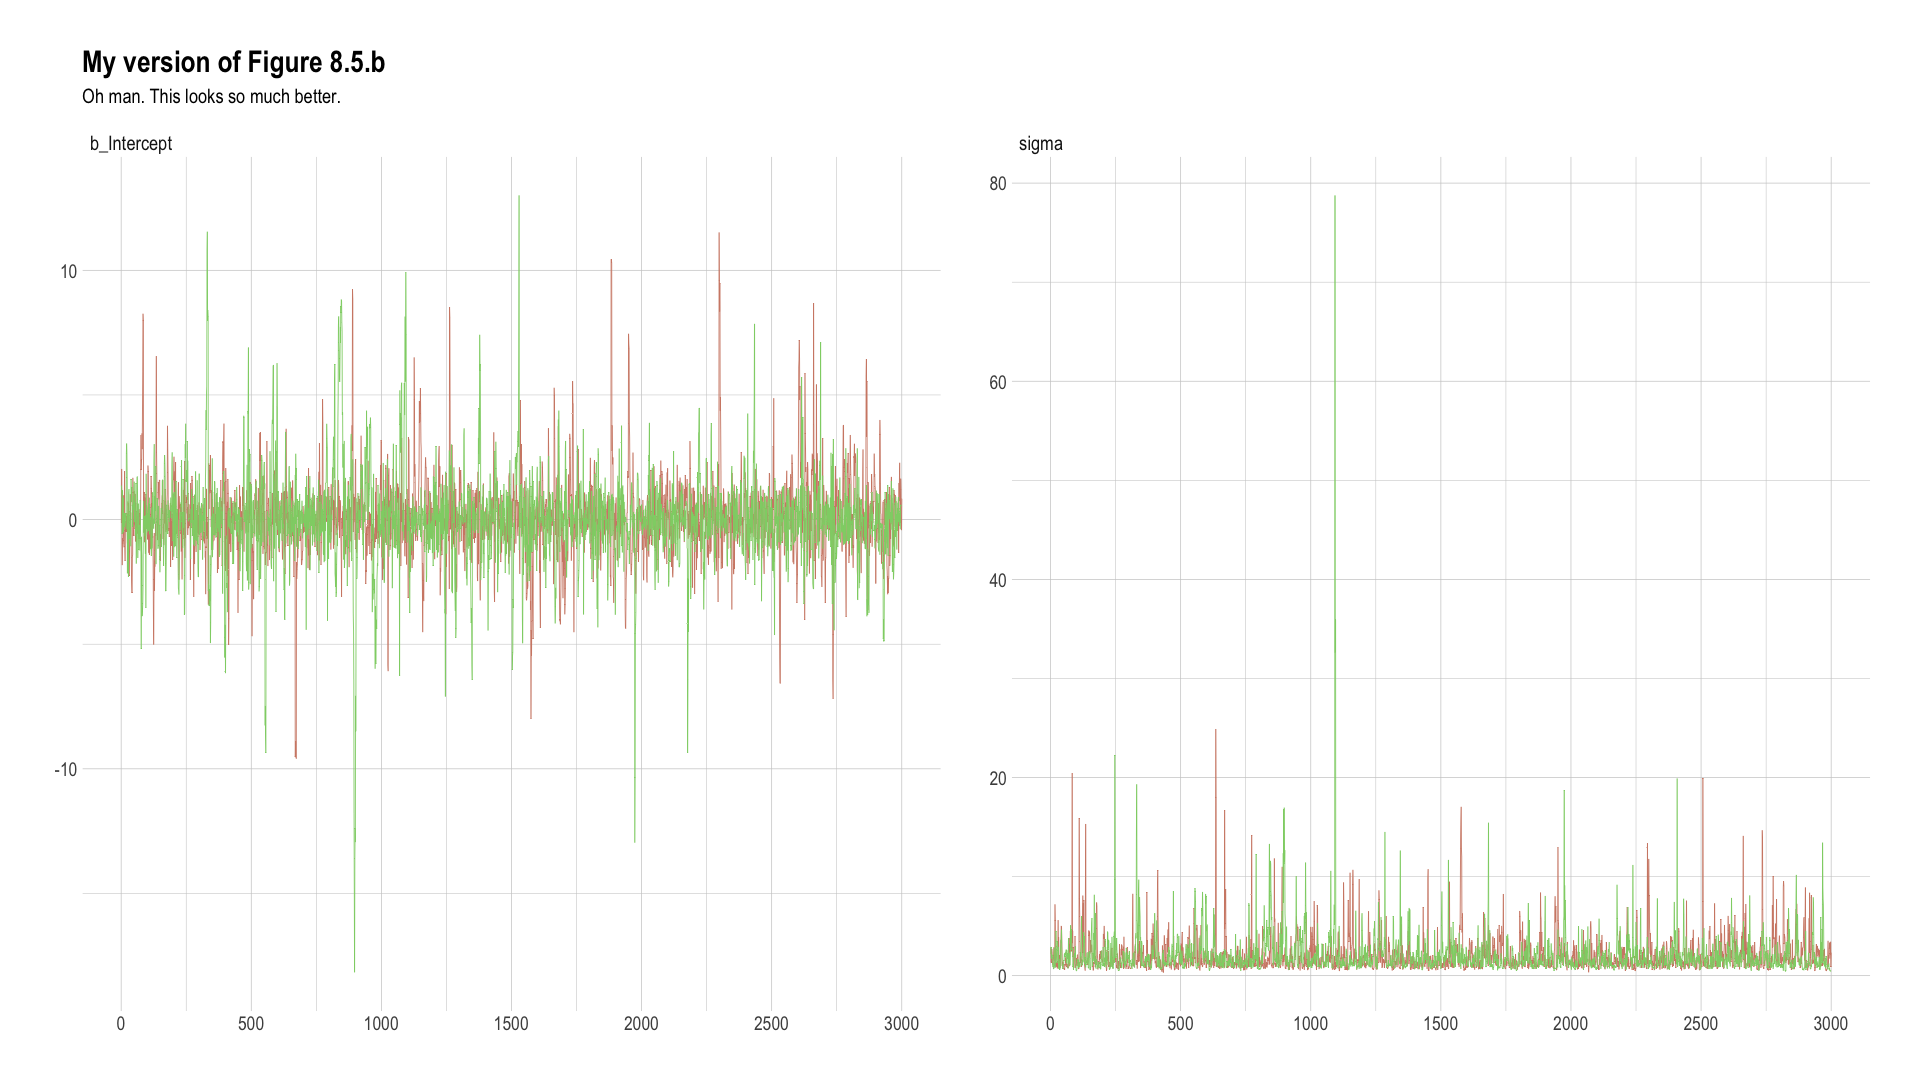

In [73]:
post <- posterior_samples(b8.3, add_chain = T)

mcmc_trace(post[, c(1:2, 4)],
           size = .25) +
  labs(title     = "My version of Figure 8.5.b",
       subtitle  = "Oh man. This looks so much better.") +
  scale_color_ipsum() +
  theme_ipsum() +
  theme(legend.position = c(.85, 1.5),
        legend.direction = "horizontal")

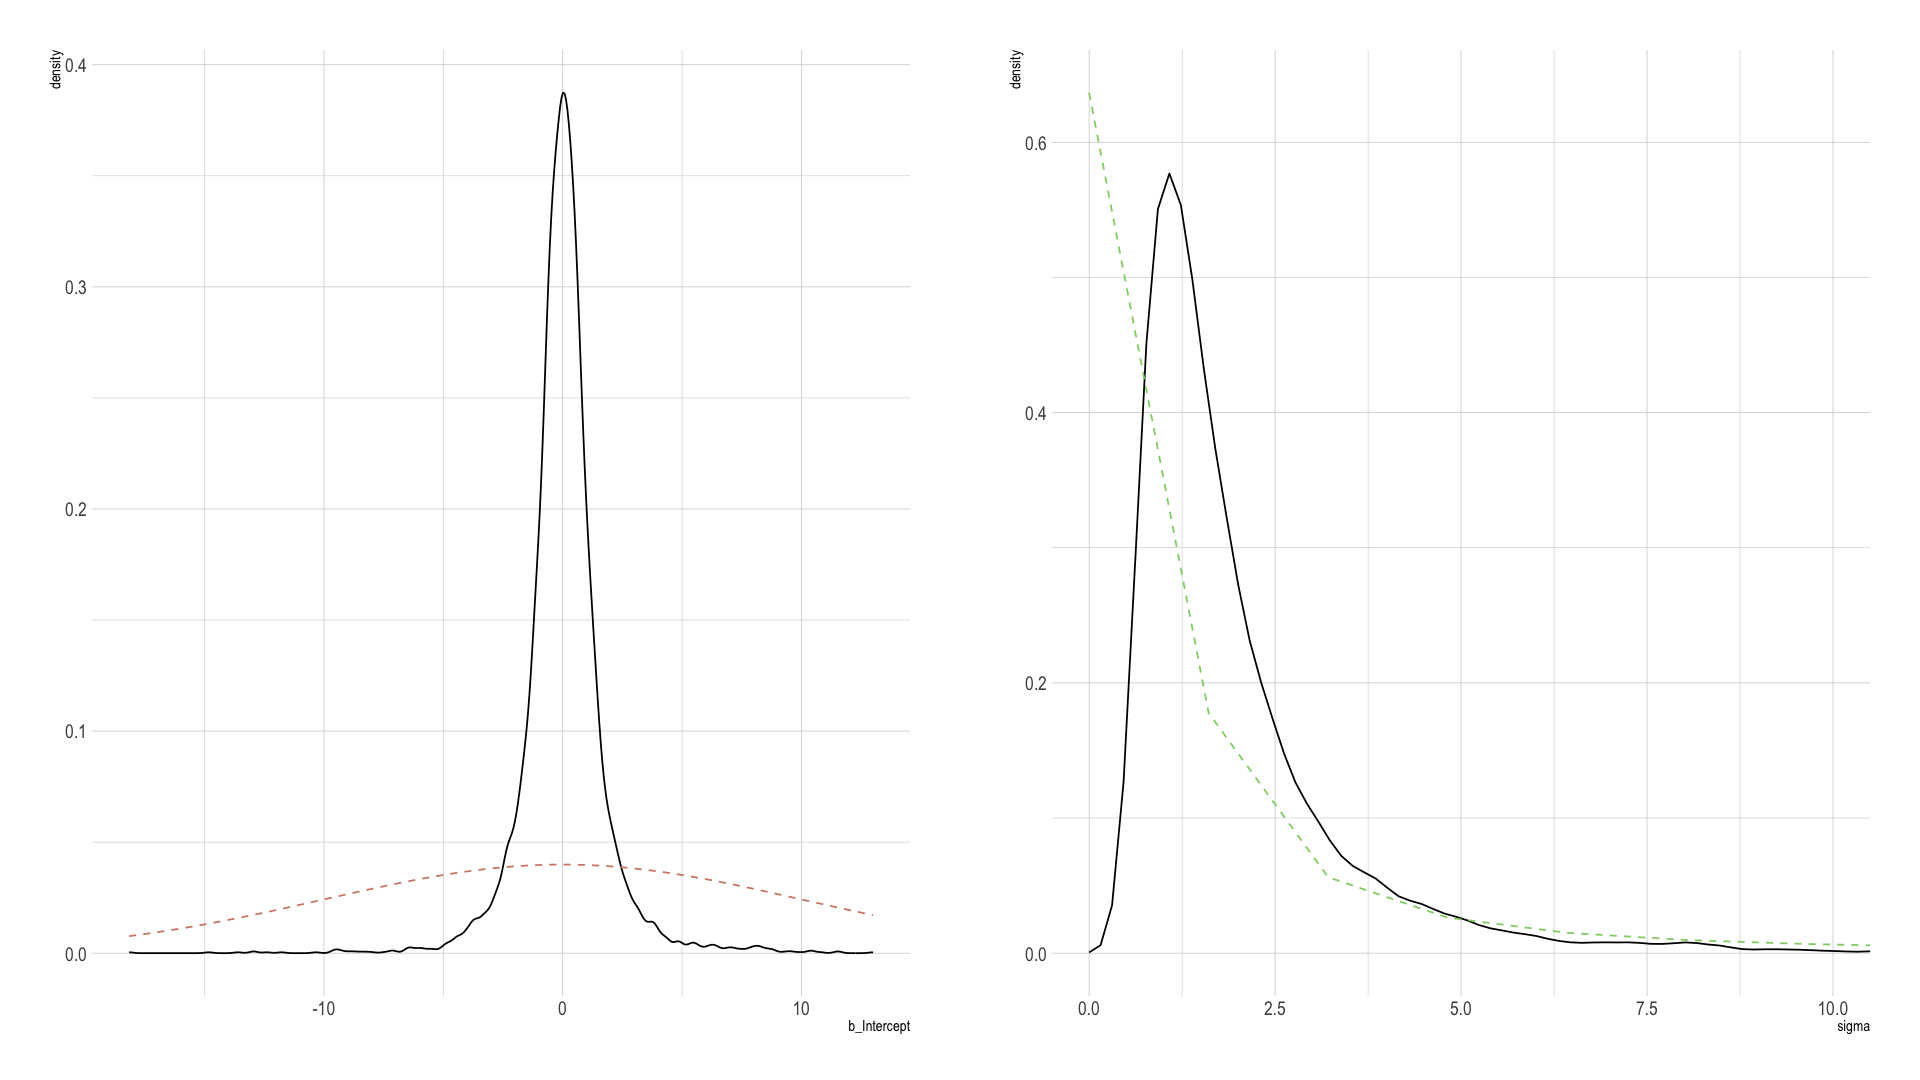

In [74]:
p3 = post %>%
  select(b_Intercept) %>%
  
  ggplot(aes(x = b_Intercept)) +
  stat_density(geom = "line") +
  geom_line(data = data.frame(x = seq(from = min(post$b_Intercept),
                                      to = max(post$b_Intercept),
                                      length.out = 50)),
            aes(x = x, y = dnorm(x = x, mean = 0, sd = 10)),
            color = ipsum_pal()(1), linetype = 2) +
  theme_ipsum()

p4 = post %>%
  select(sigma) %>%
  
  ggplot(aes(x = sigma)) +
  stat_density(geom = "line") +
  geom_line(data = data.frame(x = seq(from = 0,
                                      to = max(post$sigma),
                                      length.out = 50)),
            aes(x = x, y = dcauchy(x = x, location = 0, scale = 1)*2),
            color = ipsum_pal()(2)[2], linetype = 2) +
  coord_cartesian(xlim = c(0, 10)) +
  theme_ipsum()

cowplot::plot_grid(p3, p4, ncol = 2)

### 柯西分布
$$p\left(x | x_{0}, \gamma\right)=\left(\pi \gamma\left[1+\left(\frac{x-x_{0}}{\gamma}\right)^{2}\right]\right)^{-1}$$

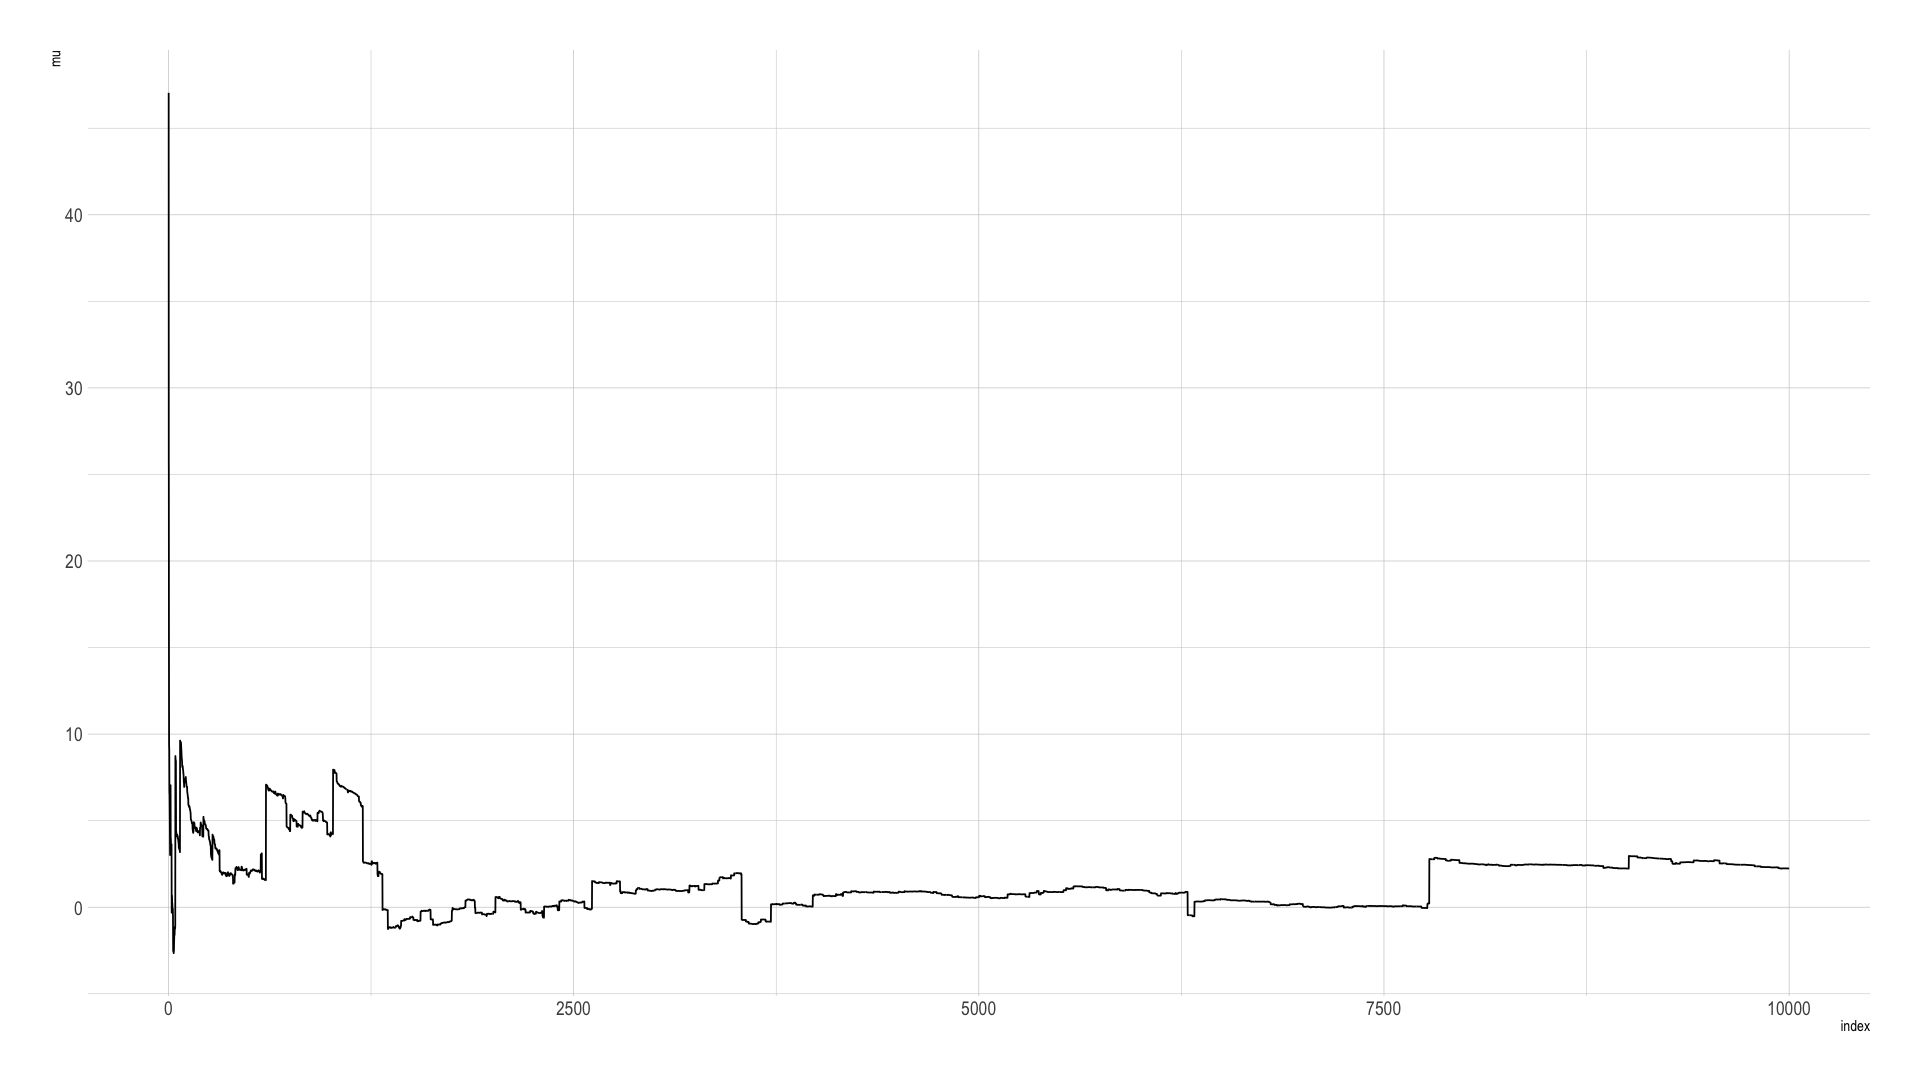

In [75]:
n <- 1e4

set.seed(8)
tibble(y     = rcauchy(n, location = 0, scale = 5),
       mu    = cummean(y),
       index = 1:n) %>% 
  
  ggplot(aes(x = index, y = mu)) +
  geom_line() +
  theme_ipsum()

### 柯西分布8次模拟

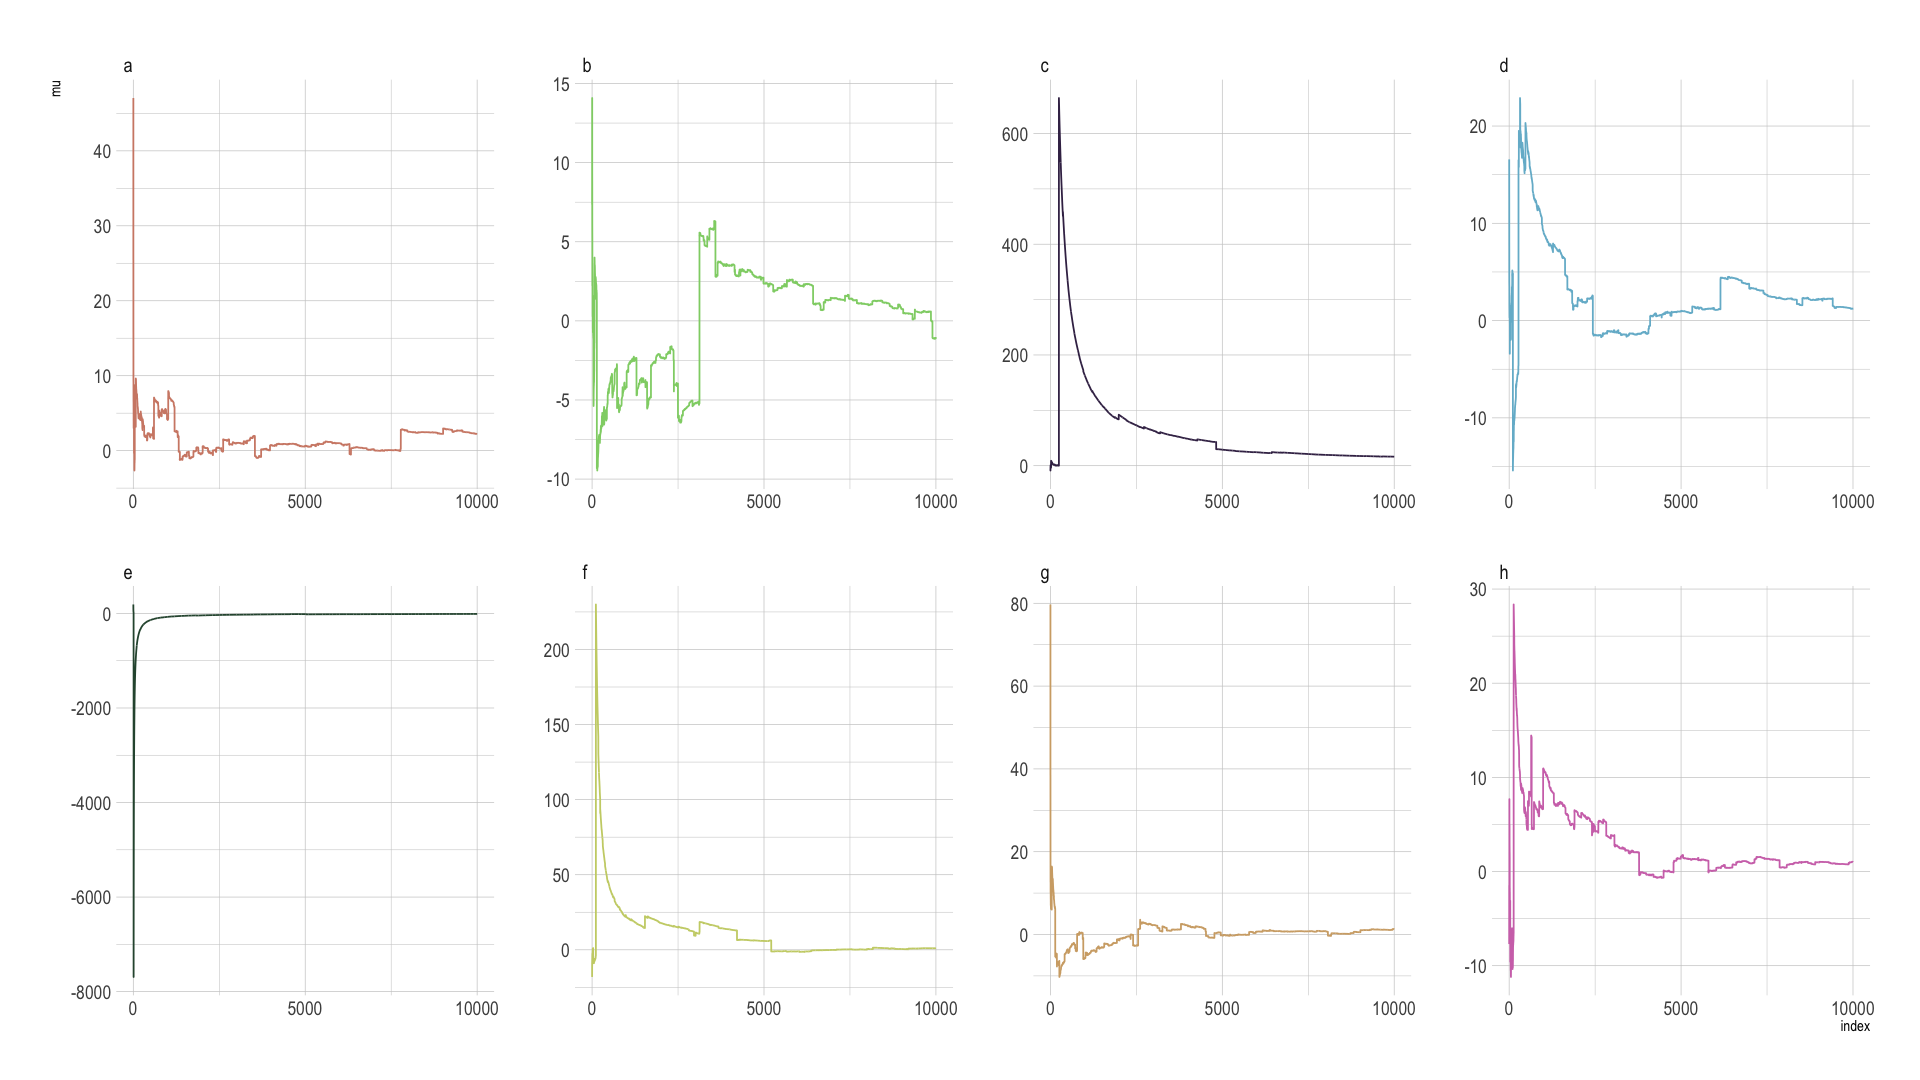

In [81]:
n <- 1e4

set.seed(8)
tibble(a = rcauchy(n, location = 0, scale = 5),
       b = rcauchy(n, location = 0, scale = 5),
       c = rcauchy(n, location = 0, scale = 5),
       d = rcauchy(n, location = 0, scale = 5),
       e = rcauchy(n, location = 0, scale = 5),
       f = rcauchy(n, location = 0, scale = 5),
       g = rcauchy(n, location = 0, scale = 5),
       h = rcauchy(n, location = 0, scale = 5)) %>% 
  gather() %>% 
  group_by(key) %>% 
  mutate(mu = cummean(value)) %>% 
  ungroup() %>% 
  mutate(index = rep(1:n, times = 8)) %>% 

  ggplot(aes(x = index, y = mu)) +
  geom_line(aes(color = key)) +
  scale_color_manual(values = ipsum_pal()(8)) +
  scale_x_continuous(breaks = c(0, 5000, 10000)) +
  theme_ipsum() +
  theme(legend.position = "none") +
  facet_wrap(~key, ncol = 4, scales = "free")

## 不可估参数

### 模拟 100 个服从均值为 0 标准差为 1 的观测
\begin{aligned} y_{i} & \sim \operatorname{Normal}(\mu, \sigma) \\ \mu &=\alpha_{1}+\alpha_{2} \\ \sigma & \sim \operatorname{HalfCauchy}(0,1) \end{aligned}

In [82]:
set.seed(8)
y <- rnorm(100, mean = 0, sd = 1)

b8.4 <-
  brm(data = list(y           = y,
                  intercept_1 = 1,
                  intercept_2 = 1), 
      family = gaussian,
      y ~ 0 + intercept_1 + intercept_2,
      prior = c(prior(uniform(-1e10, 1e10), class = b),
                prior(cauchy(0, 1), class = sigma)),
      inits = list(list(intercept_1 = 0, intercept_2 = 0, sigma = 1),
                   list(intercept_1 = 0, intercept_2 = 0, sigma = 1)),
      iter = 4000, warmup = 1000, chains = 2,
      seed = 8)

print(b8.4)

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '33c7381dd795d1f5ffc12a5fccf642d8' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 4000 [ 25%]  (Sampling)
Chain 1: Iteration: 1400 / 4000 [ 35%]  (Sampling)
Chain 1: Iteration: 1800 / 4000 [ 45%]  (Sampling)
Chain 1: Iteration: 2200 / 4000 [ 55%]  (Sampling)
Chain 1: Iteration: 2600 / 4000 [ 65%]  (Sampling)
Chain 1: Iteration: 3000 / 4000 [ 75%]  (Sampling)
Chain 1: Iteration: 3400 / 4000 [ 85%]  (Sampling)
Chain 1: Iteration: 3800 / 4000 [ 95%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.39111 seconds (Warm-up)
Chain 1:                12.2255 seconds (Sampli

Warning message:
“There were 4914 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 2.53, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”
Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful 

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: y ~ 0 + intercept_1 + intercept_2 
   Data: list(y = y, intercept_1 = 1, intercept_2 = 1) (Number of observations: 100) 
Samples: 2 chains, each with iter = 4000; warmup = 1000; thin = 1;
         total post-warmup samples = 6000

Population-Level Effects: 
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
intercept_1  -118.40   1513.42 -2685.34  2723.23 2.53        2       21
intercept_2   118.30   1513.43 -2723.26  2685.36 2.53        2       21

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     1.10      0.08     0.96     1.26 1.05       24       67

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


In [83]:
b8.5 <-
  brm(data = list(y           = y,
                  intercept_1 = 1,
                  intercept_2 = 1),
      family = gaussian,
      y ~ 0 + intercept_1 + intercept_2,
      prior = c(prior(normal(0, 10), class = b),    #具有弱信息先验
                prior(cauchy(0, 1), class = sigma)),
      inits = list(list(intercept_1 = 0, intercept_2 = 0, sigma = 1),
                   list(intercept_1 = 0, intercept_2 = 0, sigma = 1)),
      iter = 4000, warmup = 1000, chains = 2,
      seed = 8)

print(b8.5)

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '2828f45b72a00aabcd361359fe75feb0' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 4000 [ 25%]  (Sampling)
Chain 1: Iteration: 1400 / 4000 [ 35%]  (Sampling)
Chain 1: Iteration: 1800 / 4000 [ 45%]  (Sampling)
Chain 1: Iteration: 2200 / 4000 [ 55%]  (Sampling)
Chain 1: Iteration: 2600 / 4000 [ 65%]  (Sampling)
Chain 1: Iteration: 3000 / 4000 [ 75%]  (Sampling)
Chain 1: Iteration: 3400 / 4000 [ 85%]  (Sampling)
Chain 1: Iteration: 3800 / 4000 [ 95%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.872609 seconds (Warm-up)
Chain 1:                2.9096 seconds (Sampli

Warning message in facet_args$facets <- ~parameter:
“把公式左手强迫变成串列”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message in facet_args$facets <- ~parameter:
“把公式左手强迫变成串列”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



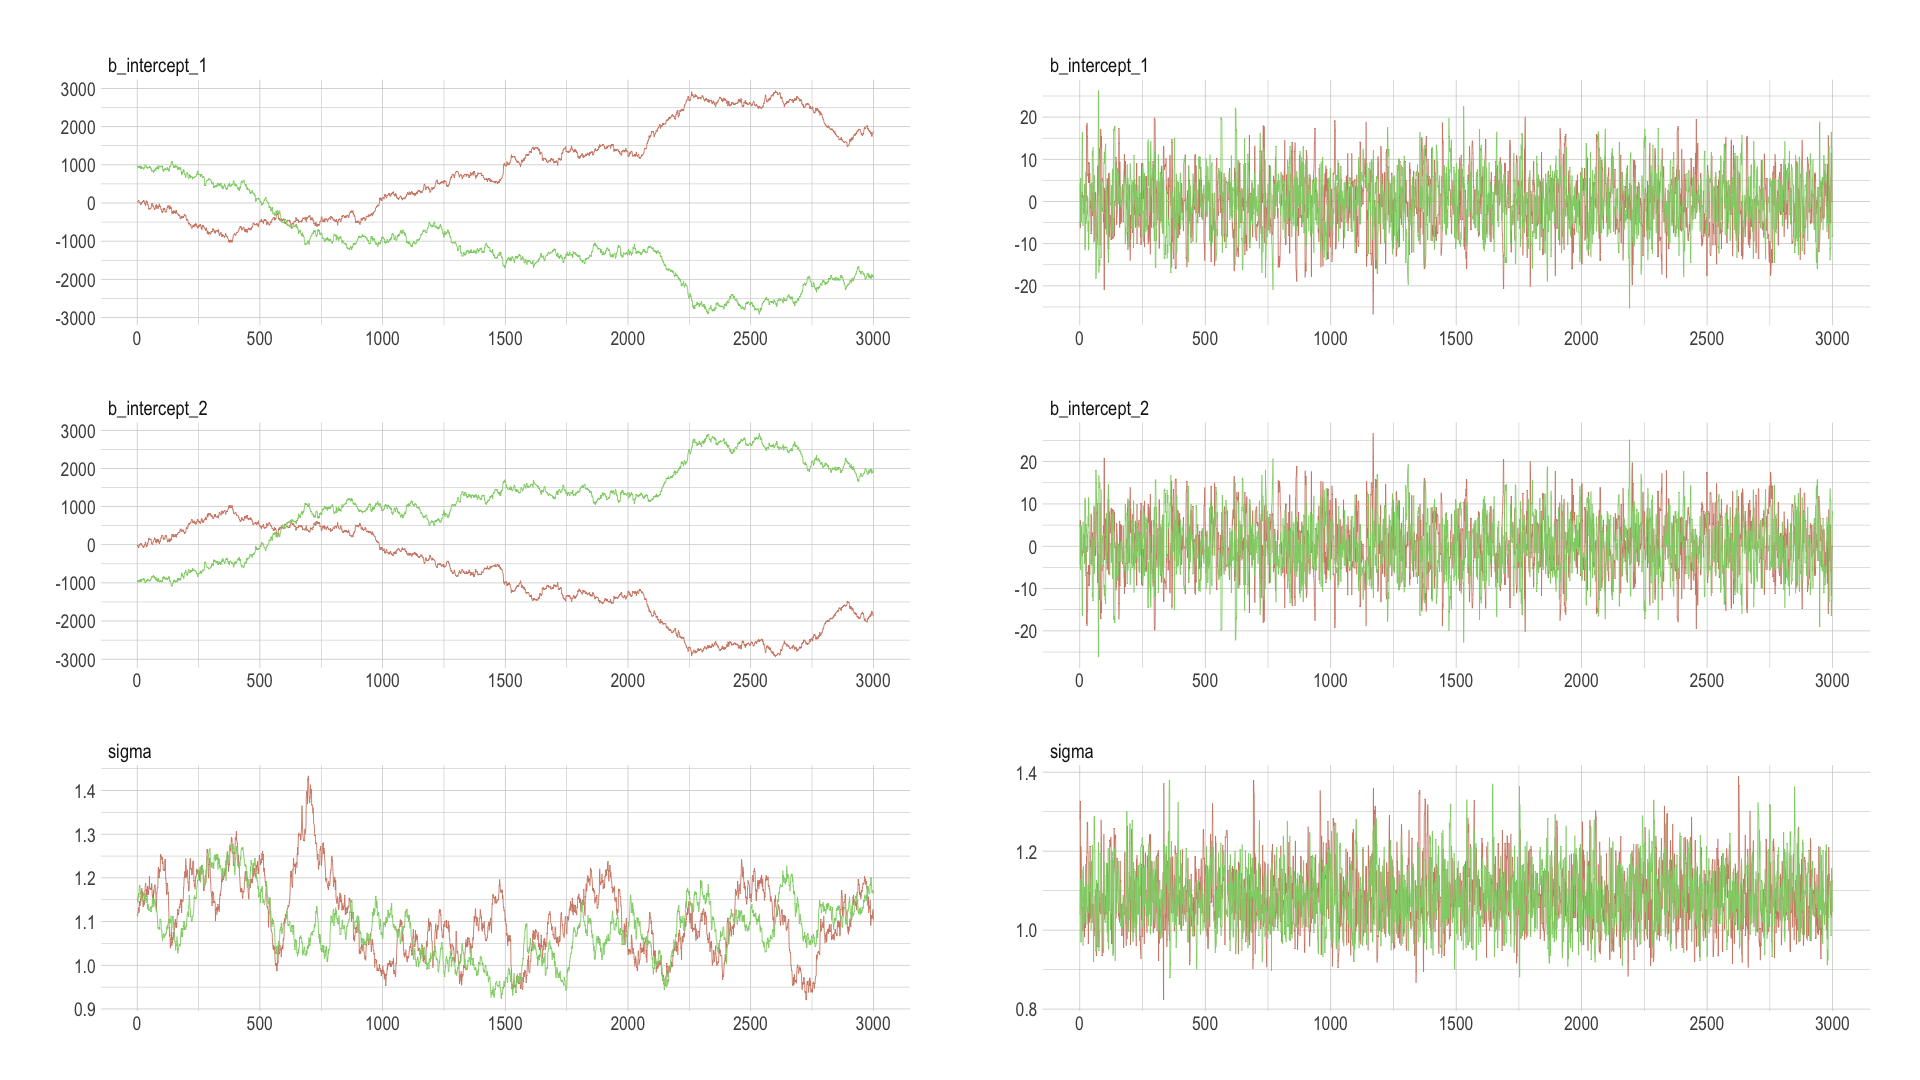

In [84]:
post <- posterior_samples(b8.4, add_chain = T)

left_column <-
  mcmc_trace(post[, c(1:3, 5)],
           size = .25,
           facet_args = c(ncol = 1)) +
  scale_color_ipsum() +
  theme_ipsum() +
  theme(legend.position  = c(.85, 1.5),
        legend.direction = "horizontal")

post <- posterior_samples(b8.5, add_chain = T)

right_column <-
  mcmc_trace(post[, c(1:3, 5)],
             size = .25,
             facet_args = c(ncol = 1)) +
  scale_color_ipsum() +
  theme_ipsum() +
  theme(legend.position  = c(.85, 1.5),
        legend.direction = "horizontal")

cowplot::plot_grid(left_column, right_column, ncol = 2)

In [85]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Catalina 10.15.3

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] zh_CN.UTF-8/zh_CN.UTF-8/zh_CN.UTF-8/C/zh_CN.UTF-8/zh_CN.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bayesplot_1.7.1      repr_1.1.0           GGally_1.4.0        
 [4] tidybayes_2.0.1      brms_2.12.0          Rcpp_1.0.3          
 [7] dagitty_0.2-2        rstan_2.19.3         StanHeaders_2.21.0-1
[10] extrafont_0.17       forcats_0.5.0        stringr_1.4.0       
[13] dplyr_0.8.4          purrr_0.3.3          readr_1.3.1         
[16] tidyr_1.0.2          tibble_2.1.3         ggplot2_3.3.0       
[19] tidyverse_1.3.0      hrbrthemes_0.8.0    

loaded via a namespace (